This code implements a Deep Deterministic Policy Gradient (DDPG) algorithm for portfolio optimization. Here's a detailed technical breakdown:

1. Core Components:

a) Environment (PortfolioEnv):
- Implements a custom OpenAI Gym environment for portfolio management
- State space: Market data including price ratios, volume ratios, and price amplitudes
- Action space: Portfolio weights for each asset (including cash and short positions)
- Reward function: Logarithmic returns defined as:
  $$r_t = \log(\frac{p_t + \epsilon}{p_{t-1} + \epsilon})$$
  where $p_t$ is the portfolio value at time t

b) DDPG Algorithm:
- Actor-Critic architecture with deterministic policy
- Actor network maps states to actions (portfolio weights)
- Critic network estimates Q-values for state-action pairs
- Uses experience replay buffer for stable learning
- Implements target networks for both actor and critic

2. Mathematical Framework:

The portfolio optimization process follows these key equations:

a) Portfolio Value Update:
$$p_t = p_{t-1}(1-\mu_t)(w_t^T y_t)(1-c)$$
where:
- $p_t$ is portfolio value at time t
- $\mu_t$ is transaction cost
- $w_t$ is portfolio weight vector
- $y_t$ is price relative vector
- $c$ is time cost

b) Transaction Cost:
$$\mu_t = c_0 \sum_{i=1}^m |w_{t,i} - \hat{w}_{t,i}|$$
where:
- $c_0$ is the transaction cost rate
- $w_{t,i}$ is the target weight for asset i
- $\hat{w}_{t,i}$ is the actual weight after price changes

3. Neural Network Architecture:

The code uses two types of architectures for feature extraction:

a) CNN Architecture:
- Input layer: (batch_size, num_assets, window_length, features)
- Two convolutional layers with batch normalization
- Fully connected layers for final output

b) LSTM Architecture:
- Input reshaping to (batch_size * num_assets, window_length, features)
- LSTM layer with 32 hidden units
- Reshape and flatten for final output

4. Training Process:

The training follows these steps:
1. Collect experience: (s_t, a_t, r_t, s_{t+1})
2. Sample mini-batch from replay buffer
3. Update critic by minimizing loss:
   $$L = \frac{1}{N}\sum_i(y_i - Q(s_i,a_i|\theta^Q))^2$$
   where $y_i = r_i + \gamma Q'(s_{i+1},\mu'(s_{i+1}|\theta^{\mu'})|\theta^{Q'})$
4. Update actor using policy gradient:
   $$\nabla_{\theta^\mu}J \approx \frac{1}{N}\sum_i\nabla_aQ(s,a|\theta^Q)|_{s=s_i,a=\mu(s_i)}\nabla_{\theta^\mu}\mu(s|\theta^\mu)|_{s=s_i}$$

5. Performance Metrics:

The code tracks several performance metrics:
- Portfolio value over time
- Sharpe ratio: $\frac{\mathbb{E}[r_t - r_f]}{\sigma_{r_t}}$
- Maximum drawdown: $\max_{t}(\max_{\tau \leq t}\frac{V_\tau - V_t}{V_\tau})$
- Transaction costs
- Market value comparison

6. Implementation Details:

- Uses TensorFlow and tflearn for neural network implementation
- Implements Ornstein-Uhlenbeck process for exploration noise
- Applies batch normalization for stable training
- Uses Adam optimizer for both networks
- Implements soft target network updates with parameter τ

The code runs experiments on different time periods (Jan-Oct) to evaluate the strategy's performance across different market conditions. It compares the DDPG strategy against two benchmarks:
1. Equal-weight buy-and-hold portfolio
2. Best-performing asset from previous month

This implementation represents a sophisticated approach to automated portfolio management, combining deep learning with reinforcement learning to learn optimal trading strategies directly from market data.

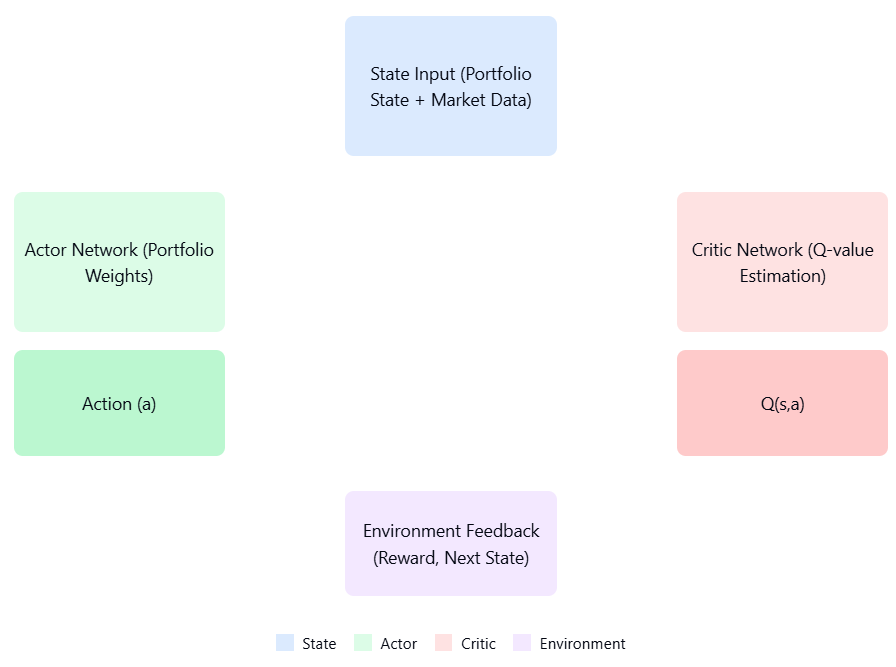

In [0]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
# for compatible with python 3
from __future__ import print_function
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [0]:
# Seaborn, useful for graphics
import seaborn as sns

# Import Bokeh modules for interactive plotting
import bokeh.io
#import bokeh.mpl
import bokeh.plotting

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline.  There is a bug, so uncomment if it works.
# %config InlineBackend.figure_formats = {'svg',}

# This enables high resolution PNGs. SVG is preferred, but has problems
# rendering vertical and horizontal lines
%config InlineBackend.figure_formats = {'png', 'retina'}
matplotlib.rcParams['figure.figsize'] = (10, 6)
plt.rc('legend', fontsize=20)
# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Set up Bokeh for inline viewing
bokeh.io.output_notebook()

### Data Load

In [0]:
import pandas as pd
dataset = pd.read_csv('stock_price_minutes.csv')

--2020-01-11 23:27:22--  https://github.com/firmai/random-assets-two/blob/master/stock_price_minutes.csv.zip?raw=true
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/firmai/random-assets-two/raw/master/stock_price_minutes.csv.zip [following]
--2020-01-11 23:27:22--  https://github.com/firmai/random-assets-two/raw/master/stock_price_minutes.csv.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/firmai/random-assets-two/master/stock_price_minutes.csv.zip [following]
--2020-01-11 23:27:22--  https://raw.githubusercontent.com/firmai/random-assets-two/master/stock_price_minutes.csv.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw

In [0]:
dataset.head()

Unnamed: 0  date_index      date  ...  XOM_low  XOM_close  XOM_vol
0           0           0  20180102  ...    83.77      83.77      800
1           1           1  20180102  ...    83.80      83.94     1391
2           2           2  20180102  ...    83.84      83.90     9400
3           3           3  20180102  ...    83.82      83.86     8728
4           4           4  20180102  ...    83.79      83.79     5430

[5 rows x 79 columns]

In [0]:
df_time = pd.DataFrame({'year': dataset.date.astype(str).str.slice(0, 4).astype(int),
                        'month': dataset.date.astype(str).str.slice(4, 6).astype(int),
                        'day': dataset.date.astype(str).str.slice(6, 8).astype(int),
                        'hour': dataset.time.astype(str).str.slice(0, 2).astype(int),
                        'minute': dataset.time.astype(str).str.slice(2, 4).astype(int)
                       })

In [0]:
time_ref = pd.to_datetime(df_time)
time_ref = time_ref.to_frame()
time_ref.columns = ['Time']

In [0]:
time_ref.head()

Time
0 2018-01-02 17:31:00
1 2018-01-02 17:32:00
2 2018-01-02 17:33:00
3 2018-01-02 17:34:00
4 2018-01-02 17:35:00

In [0]:
dataset = dataset.merge(time_ref, left_index=True, right_index=True, how='left')

In [0]:
abbreviation = pd.read_csv("https://github.com/firmai/random-assets/raw/master/portfolio/symbols.txt")

In [0]:
abbreviation

symbols
0     AAPL
1      BAC
2       BA
3       GE
4     GOOG
5      JNJ
6       KO
7       MA
8      MRK
9     MSFT
10    NVDA
11     PFE
12    SBUX
13       T
14     XOM

In [0]:
history = np.empty((15,len(dataset),5))

In [0]:
suffix = ["_open", "_close", "_high", "_low", "_vol"]

In [0]:
for i_n, i in enumerate(abbreviation['symbols']):
    for j_n, j in enumerate(suffix):
        history[i_n, :, j_n] = dataset[i+j]

In [0]:
history.shape

(15, 81101, 5)

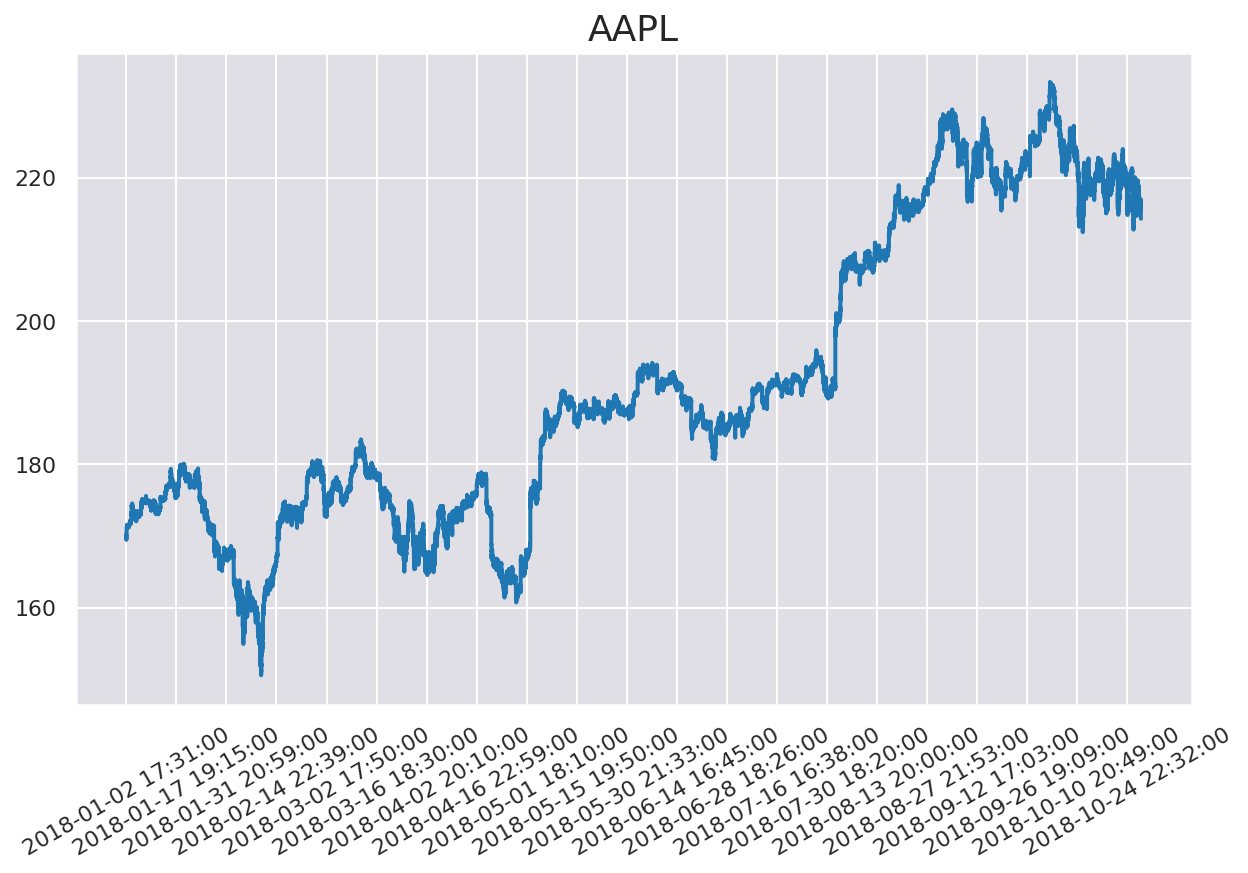

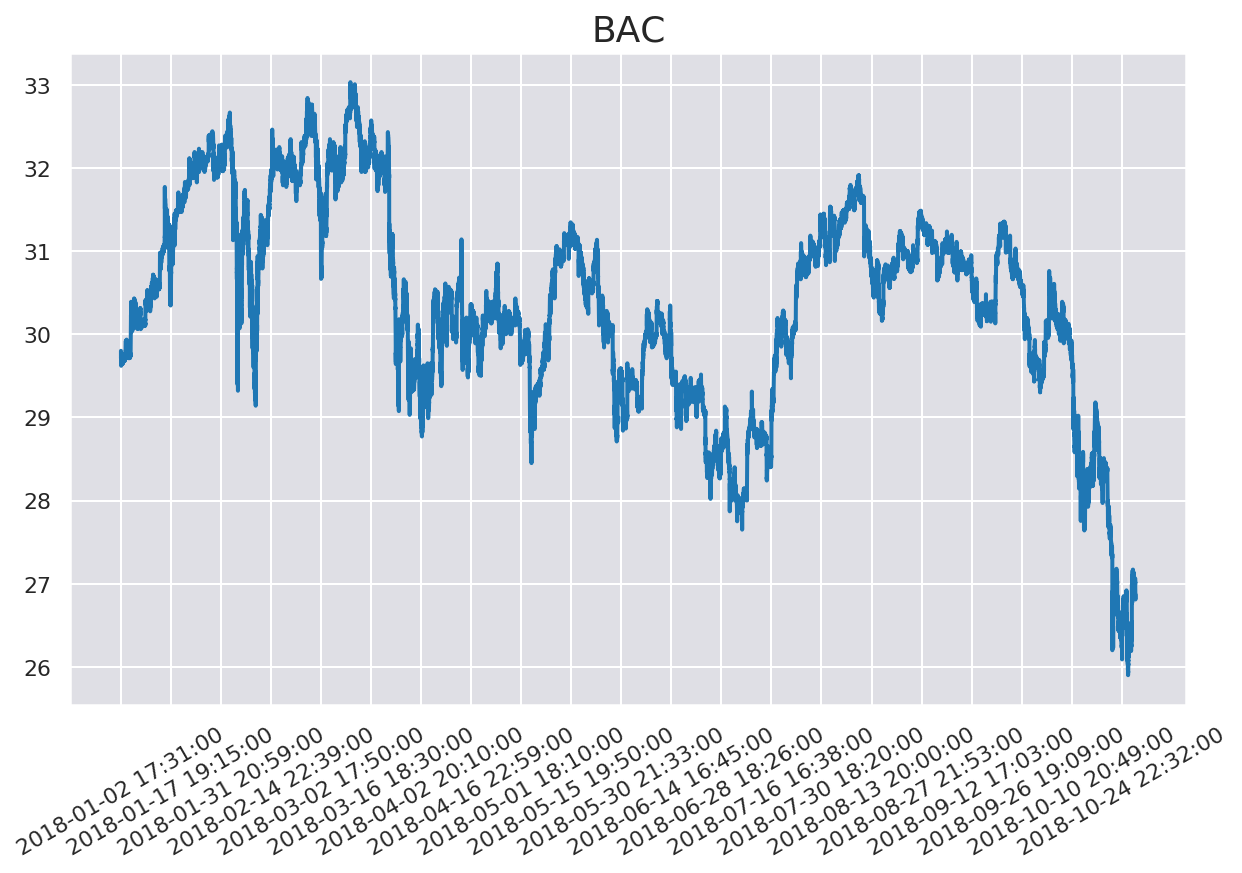

In [0]:
# visualize stocks open price from 2018-01-01 to 2018-10-29 for the first two stocks
if True:
    date = dataset.Time
    x = range(history.shape[1])
    for i in range(len(abbreviation[:2])):
        plt.figure(i)
        plt.plot(x, history[i, :, 0])  # open, cloase, high, low, volume = [0, 1, 2, 3, 4]
        plt.xticks(x[::4000], date[::4000], rotation=30)
        plt.title(abbreviation.iloc[i, 0])
        plt.show()

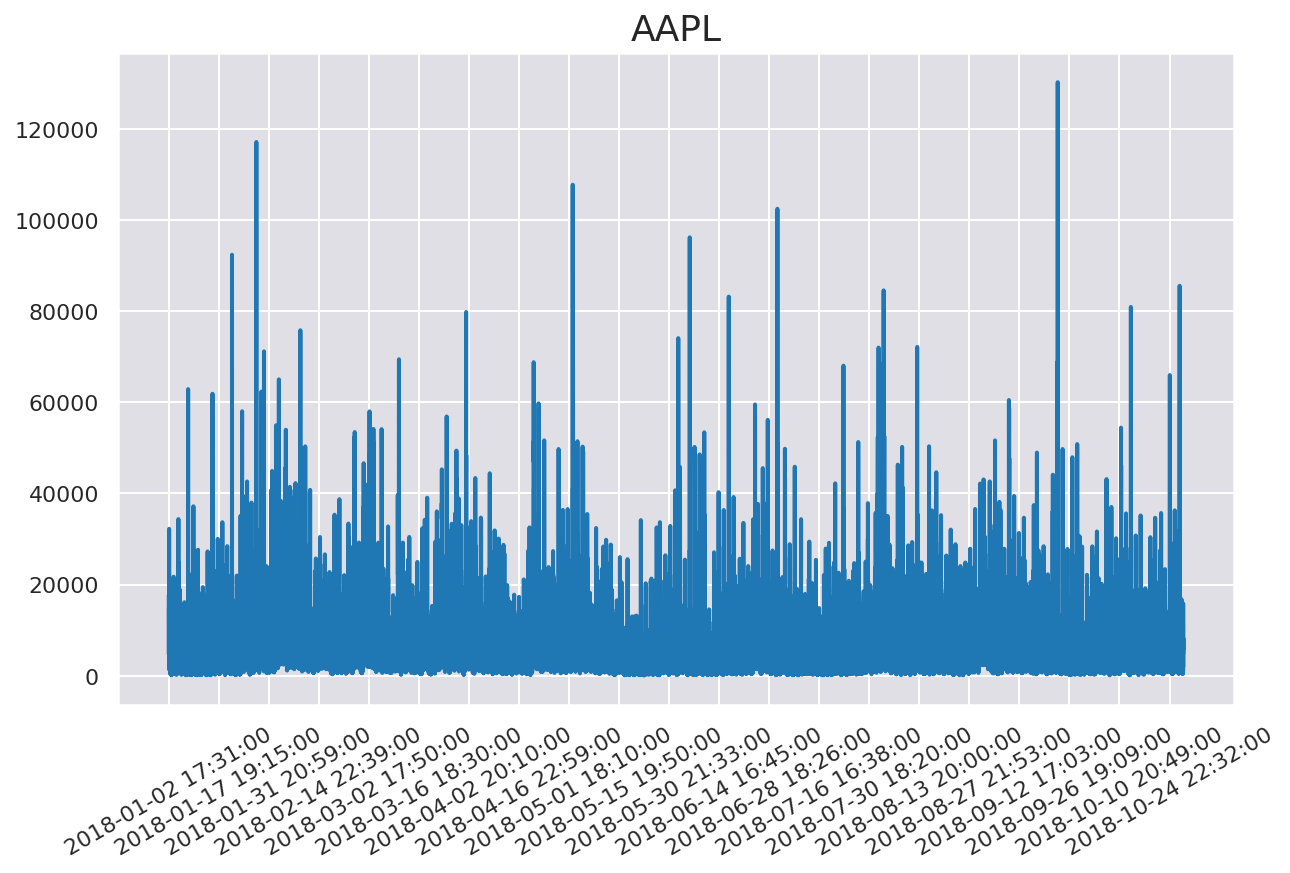

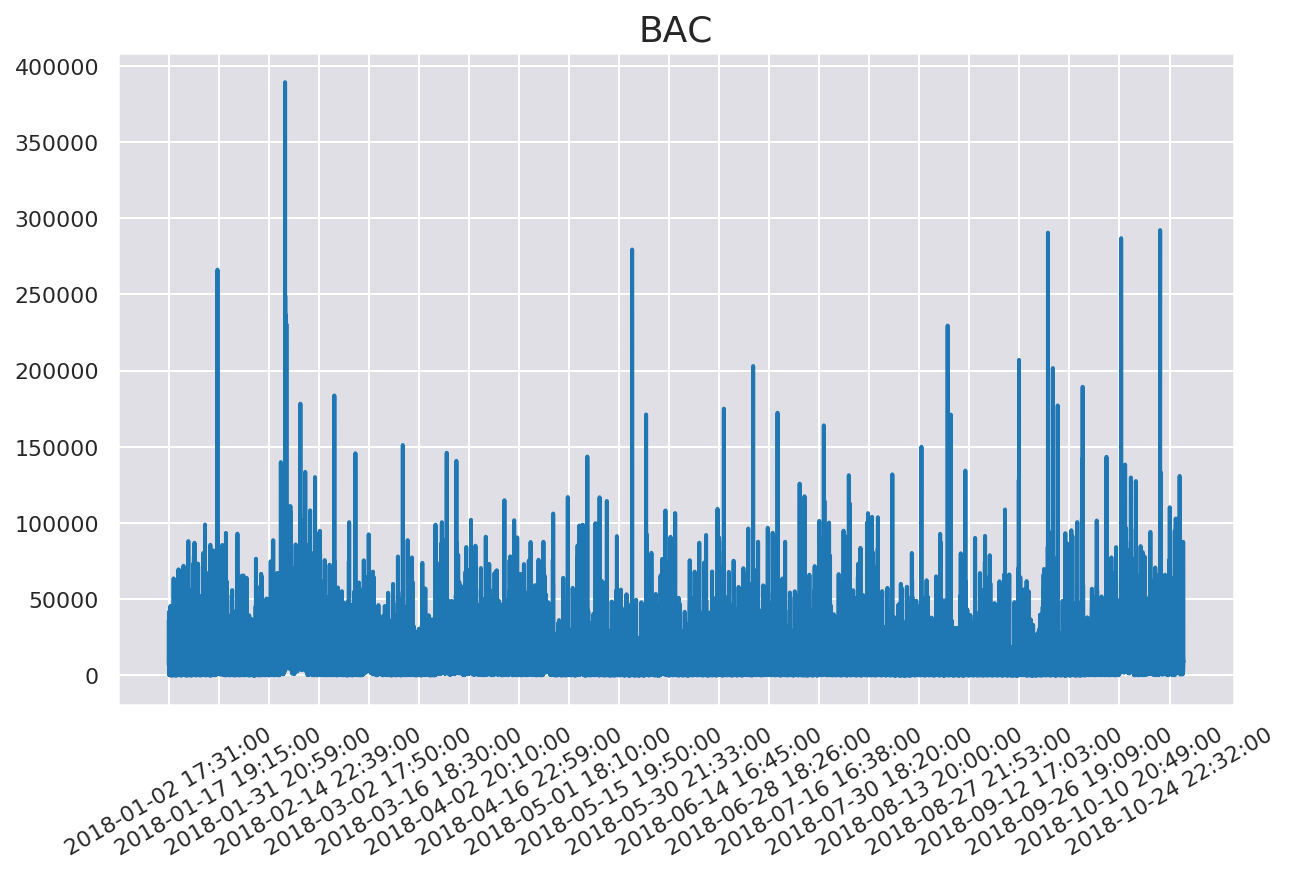

In [0]:
# visualize stocks trade volume
if True:
    date = dataset.Time
    x = range(history.shape[1])
    for i in range(len(abbreviation[:2])):
        plt.figure(i)
        plt.plot(x, history[i, :, 4])  # open, cloase, high, low, volume = [0, 1, 2, 3, 4]
        plt.xticks(x[::4000], date[::4000], rotation=30)
        plt.title(abbreviation.iloc[i, 0])
        plt.show()

In [0]:
# from model.ddpg.actor import ActorNetwork
# from model.ddpg.critic import CriticNetwork
# from model.ddpg.ddpg import DDPG
# from model.ddpg.ornstein_uhlenbeck import OrnsteinUhlenbeckActionNoise

# from stock_trading import StockActor, StockCritic, obs_normalizer, get_model_path, get_result_path, \
#                           test_model, get_variable_scope

# from environment.portfolio import PortfolioEnv

import numpy as np
import tflearn
import tensorflow as tf



 Train the DDPG model with stock price data every month and play in the next month.

In [0]:
data = {
    'Jan': dataset[(dataset.Time <= pd.Timestamp(2018, 1, 31)) & (dataset.Time >= pd.Timestamp(2018, 1, 1))],
    'Feb': dataset[(dataset.Time <= pd.Timestamp(2018, 2, 28)) & (dataset.Time >= pd.Timestamp(2018, 2, 1))],
    'Mar': dataset[(dataset.Time <= pd.Timestamp(2018, 3, 31)) & (dataset.Time >= pd.Timestamp(2018, 3, 1))],
    'Apr': dataset[(dataset.Time <= pd.Timestamp(2018, 4, 30)) & (dataset.Time >= pd.Timestamp(2018, 4, 1))],
    'May': dataset[(dataset.Time <= pd.Timestamp(2018, 5, 31)) & (dataset.Time >= pd.Timestamp(2018, 5, 1))],
    'Jun': dataset[(dataset.Time <= pd.Timestamp(2018, 6, 30)) & (dataset.Time >= pd.Timestamp(2018, 6, 1))],
    'Jul': dataset[(dataset.Time <= pd.Timestamp(2018, 7, 31)) & (dataset.Time >= pd.Timestamp(2018, 7, 1))],
    'Aug': dataset[(dataset.Time <= pd.Timestamp(2018, 8, 31)) & (dataset.Time >= pd.Timestamp(2018, 8, 1))],
    'Sep': dataset[(dataset.Time <= pd.Timestamp(2018, 9, 30)) & (dataset.Time >= pd.Timestamp(2018, 9, 1))],
    'Oct': dataset[(dataset.Time <= pd.Timestamp(2018, 10, 31)) & (dataset.Time >= pd.Timestamp(2018, 10, 1))]
    }

In [0]:
data['Jan'].head(5)

Unnamed: 0  date_index      date  ...  XOM_close  XOM_vol                Time
0           0           0  20180102  ...      83.77      800 2018-01-02 17:31:00
1           1           1  20180102  ...      83.94     1391 2018-01-02 17:32:00
2           2           2  20180102  ...      83.90     9400 2018-01-02 17:33:00
3           3           3  20180102  ...      83.86     8728 2018-01-02 17:34:00
4           4           4  20180102  ...      83.79     5430 2018-01-02 17:35:00

[5 rows x 80 columns]

In [0]:
history_Jan = np.empty((15,len(data['Jan']),5))
for i_n, i in enumerate(abbreviation['symbols']):
    for j_n, j in enumerate(suffix):
        history_Jan[i_n, :, j_n] = data['Jan'][i+j]
history_Feb = np.empty((15,len(data['Feb']),5))
for i_n, i in enumerate(abbreviation['symbols']):
    for j_n, j in enumerate(suffix):
        history_Feb[i_n, :, j_n] = data['Feb'][i+j]
history_Mar = np.empty((15,len(data['Mar']),5))
for i_n, i in enumerate(abbreviation['symbols']):
    for j_n, j in enumerate(suffix):
        history_Mar[i_n, :, j_n] = data['Mar'][i+j]
history_Apr = np.empty((15,len(data['Apr']),5))
for i_n, i in enumerate(abbreviation['symbols']):
    for j_n, j in enumerate(suffix):
        history_Apr[i_n, :, j_n] = data['Apr'][i+j]
history_May = np.empty((15,len(data['May']),5))
for i_n, i in enumerate(abbreviation['symbols']):
    for j_n, j in enumerate(suffix):
        history_May[i_n, :, j_n] = data['May'][i+j]
history_Jun = np.empty((15,len(data['Jun']),5))
for i_n, i in enumerate(abbreviation['symbols']):
    for j_n, j in enumerate(suffix):
        history_Jun[i_n, :, j_n] = data['Jun'][i+j]
history_Jul = np.empty((15,len(data['Jul']),5))
for i_n, i in enumerate(abbreviation['symbols']):
    for j_n, j in enumerate(suffix):
        history_Jul[i_n, :, j_n] = data['Jul'][i+j]
history_Aug = np.empty((15,len(data['Aug']),5))
for i_n, i in enumerate(abbreviation['symbols']):
    for j_n, j in enumerate(suffix):
        history_Aug[i_n, :, j_n] = data['Aug'][i+j]
history_Sep = np.empty((15,len(data['Sep']),5))
for i_n, i in enumerate(abbreviation['symbols']):
    for j_n, j in enumerate(suffix):
        history_Sep[i_n, :, j_n] = data['Sep'][i+j]
history_Oct = np.empty((15,len(data['Oct']),5))
for i_n, i in enumerate(abbreviation['symbols']):
    for j_n, j in enumerate(suffix):
        history_Oct[i_n, :, j_n] = data['Oct'][i+j]

In [0]:
batch_size = 100
action_bound = 1.
tau = 1e-3
window_length = 30
predictor_type = 'lstm'
use_batch_norm = True
nb_classes = 15

### Portfolio Environment

In [0]:
from __future__ import print_function

from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gym
import gym.spaces


eps = 1e-20

dats = dataset.copy()

df_time = pd.DataFrame({'year': dats.date.astype(str).str.slice(0, 4).astype(int),
                        'month': dats.date.astype(str).str.slice(4, 6).astype(int),
                        'day': dats.date.astype(str).str.slice(6, 8).astype(int),
                        'hour': dats.time.astype(str).str.slice(0, 2).astype(int),
                        'minute': dats.time.astype(str).str.slice(2, 4).astype(int)
                        })
df_time = pd.to_datetime(df_time).to_frame()
df_time.columns = ['Time']

def random_shift(x, fraction):
    """ Apply a random shift to a pandas series. """
    min_x, max_x = np.min(x), np.max(x)
    m = np.random.uniform(-fraction, fraction, size=x.shape) + 1
    return np.clip(x * m, min_x, max_x)


def scale_to_start(x):
    """ Scale pandas series so that it starts at one. """
    x = (x + eps) / (x[0] + eps)
    return x


def sharpe(returns, freq=30, rfr=0):
    """ Given a set of returns, calculates naive (rfr=0) sharpe (eq 28). """
    return (np.sqrt(freq) * np.mean(returns - rfr + eps)) / np.std(returns - rfr + eps)


def max_drawdown(returns):
    """ Max drawdown. See https://www.investopedia.com/terms/m/maximum-drawdown-mdd.asp """
    peak = returns.max()
    trough = returns[returns.argmax():].min()
    return (trough - peak) / (peak + eps)


class DataGenerator(object):
    """Acts as data provider for each new episode."""

    def __init__(self, history, abbreviation, steps=120, window_length=50):
        """
        Args:
            history: (num_stocks, timestamp, 5) open, close, high, low, volume
            abbreviation: a list of length num_stocks with assets name
            steps: the total number of steps to simulate, default is 2 hours
            window_length: observation window
        """
        assert history.shape[0] == len(abbreviation), 'Number of stock is not consistent'
        import copy

        self.steps = steps + 1
        self.window_length = window_length

        # make immutable class
        self._data = history.copy()  # all data
        self.asset_names = copy.copy(abbreviation)

    def _step(self):
        # get observation matrix from history
        # the stock data were observed every 7 minutes
        self.step += 7
        obs = self.data[:, self.step:self.step + self.window_length, :].copy()
        # normalize obs with open price

        # used for compute optimal action and sanity check
        ground_truth_obs = self.data[:, self.step + self.window_length:self.step + self.window_length + 1, :].copy()

        done = self.step + 7 >= self.steps
        return obs, done, ground_truth_obs

    def _step_sim(self):
        # get observation without stepping forward
        obs = self.data[:, self.step:self.step + self.window_length, :].copy()

        # used for compute optimal action and sanity check
        ground_truth_obs = self.data[:, self.step + self.window_length:self.step + self.window_length + 1, :].copy()

        done = self.step + 7 >= self.steps
        return obs, done, ground_truth_obs

    def reset(self):
        self.step = 0

        # get data for this episode, each episode might be different.
        self.idx = np.random.randint(
            low=self.window_length, high=self._data.shape[1] - self.steps)

        # print('Start date: {}'.format(index_to_date(self.idx)))
        data = self._data[:, self.idx - self.window_length:self.idx + self.steps + 7, :]
        # apply augmentation?
        self.data = data
        return self.data[:, self.step:self.step + self.window_length, :].copy(), \
               self.data[:, self.step + self.window_length:self.step + self.window_length + 1, :].copy()


class PortfolioSim(object):
    """
    Portfolio management sim.
    Params:
    - cost e.g. 0.0025 is max in Poliniex
    Based of [Jiang 2017](https://arxiv.org/abs/1706.10059)
    """

    def __init__(self, asset_names=list(), returns_list=list(), steps=730, trading_cost=0.0025, time_cost=0.0):
        self.asset_names = asset_names
        self.returns_list = returns_list
        self.cost = trading_cost
        self.time_cost = time_cost
        self.steps = steps

    def _step(self, w1, y1):
        """
        Step.
        w1 - new action of portfolio weights - e.g. [0.1,0.9,0.0]
        y1 - price relative vector also called return
            e.g. [1.0, 0.9, 1.1]
        Numbered equations are from https://arxiv.org/abs/1706.10059
        """
        assert w1.shape == y1.shape, 'w1 and y1 must have the same shape'
        assert y1[0] == 1.0, 'y1[0] must be 1'

        w0 = self.w0
        p0 = self.p0
        n_assests = len(self.asset_names)

        dw1 = (y1 * w0) / (np.dot(y1, w0) + eps)  # (eq7) weights evolve into

        mu1 = self.cost * (np.abs(dw1[1:] - w1[1:])).sum() # (eq16) cost to change portfolio

        assert mu1 < 1.0, 'Cost is larger than current holding'

        LongPosition_value = p0 * (1 - mu1) * np.dot(y1[:n_assests+1], w0[:n_assests+1])
        ShortPosition_value = p0 * (1 - mu1) * np.dot(1-(y1[n_assests+1:]-1), w0[n_assests+1:])

        p1 = LongPosition_value + ShortPosition_value

        p1 = p1 * (1 - self.time_cost)  # we can add a cost to holding

        rho1 = p1 / p0 - 1  # rate of returns

        r1 = np.log((p1 + eps) / (p0 + eps))  # log rate of return

        # TODO use sharpe ratio for reward
        reward = r1/self.steps  # reward
        # remember for next step
        self.p0 = p1
        self.w0 = w1

        # if we run out of money, we're done (losing all the money)
        done = p1 == 0

        info = {
            "reward": reward,
            "log_return": r1,
            "portfolio_value": p1,
            "return": y1.mean(),
            "rate_of_return": rho1,
            "weights_mean": w1.mean(),
            "weights_std": w1.std(),
            "weights": np.round(w1, 4),
            "cost": mu1,
            "long_position": LongPosition_value,
            "short_position": ShortPosition_value,
            "price_change": y1

        }
        self.infos.append(info)
        return reward, info, done

    def reset(self):
        self.infos = []
        self.w0 = np.array([1.0] + [0.0] * len(self.asset_names) * 2)
        self.p0 = 1.0


class PortfolioEnv(gym.Env):
    """
    An environment for financial portfolio management.
    Financial portfolio management is the process of constant redistribution of a fund into different
    financial products.
    Based on [Jiang 2017](https://arxiv.org/abs/1706.10059)
    """

    metadata = {'render.modes': ['human', 'ansi']}

    def __init__(self,
                 history,
                 abbreviation,
                 steps=120,
                 trading_cost=0.0025,
                 time_cost=0.00,
                 window_length=50,
                 start_idx=0
                 ):
        """
        An environment for financial portfolio management.
        Params:
            steps - steps in episode
            scale - scale data and each episode (except return)
            augment - fraction to randomly shift data by
            trading_cost - cost of trade as a fraction
            time_cost - cost of holding as a fraction
            window_length - how many past observations to return
            start_idx - The number of days from '2018-01-02' of the dataset
        """
        self.window_length = window_length
        self.num_stocks = history.shape[0]
        self.start_idx = start_idx

        self.src = DataGenerator(history, abbreviation, steps=steps, window_length=window_length)

        self.sim = PortfolioSim(
            asset_names=abbreviation,
            trading_cost=trading_cost,
            time_cost=time_cost,
            steps=steps)

        # openai gym attributes
        # action will be the portfolio weights from 0 to 1 for each asset
        self.action_space = gym.spaces.Box(
            0, 1, shape=(len(self.src.asset_names)*2 + 1,), dtype=np.float32)  # include cash

        # get the observation space from the data min and max
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(len(abbreviation), window_length,
                                                                                 history.shape[-1]), dtype=np.float32)
        
    def step(self, action, simulation=0):
        return self._step(action, simulation)

    def _step(self, action, simulation):
        """
        Step the env.
        Actions should be portfolio [w0...]
        - Where wn is a portfolio weight from 0 to 1. The first is cash_bias
        - cn is the portfolio conversion weights see PortioSim._step for description
        """
        np.testing.assert_almost_equal(
            action.shape,
            (len(self.sim.asset_names)*2 + 1,)
        )

        # normalise just in case
        action = np.clip(action, 0, 1)

        weights = action  # np.array([cash_bias] + list(action))  # [w0, w1...]
        weights /= (weights.sum() + eps)
        weights[0] += np.clip(1 - weights.sum(), 0, 1)  # so if weights are all zeros we normalise to [1,0...]

        assert ((action >= 0) * (action <= 1)).all(), 'all action values should be between 0 and 1. Not %s' % action
        np.testing.assert_almost_equal(
            np.sum(weights), [1.0], 3, err_msg='weights should sum to 1. action="%s"' % weights)

        if simulation == 0:
            observation, done1, ground_truth_obs = self.src._step()
        else:
            observation, done1, ground_truth_obs = self.src._step_sim()

        # concatenate observation with ones
        cash_observation = np.ones((1, self.window_length, observation.shape[2]))
        observation = np.concatenate((cash_observation, observation), axis=0)
        cash_ground_truth = np.ones((1, 1, ground_truth_obs.shape[2]))
        ground_truth_obs = np.concatenate((cash_ground_truth, ground_truth_obs), axis=0)
        # relative price vector of last observation day (close/open)
        current_open_price_vector = observation[:, -1, 0]
        last_open_price_vector = observation[:, -7, 0]

        y1 = current_open_price_vector / last_open_price_vector
        y1 = np.append(y1, y1[1:])

        reward, info, done2 = self.sim._step(weights, y1)

        # calculate return for buy and hold a bit of each asset
        if simulation == 0:
            info['market_value'] = np.cumprod([inf["return"] for inf in self.infos + [info]])[-1]
            # add dates
            info['date'] = self.start_idx + self.src.idx + self.src.step
            info['steps'] = self.src.step
            info['next_obs'] = ground_truth_obs
            self.infos.append(info)

        return observation, reward, done1 or done2, info
    
    def reset(self):
        return self._reset()

    def _reset(self):
        self.infos = []
        self.sim.reset()
        observation, ground_truth_obs = self.src.reset()
        cash_observation = np.ones((1, self.window_length, observation.shape[2]))
        observation = np.concatenate((cash_observation, observation), axis=0)
        cash_ground_truth = np.ones((1, 1, ground_truth_obs.shape[2]))
        ground_truth_obs = np.concatenate((cash_ground_truth, ground_truth_obs), axis=0)
        info = {}
        info['next_obs'] = ground_truth_obs
        return observation, info

    def _render(self, mode='human', close=False):
        if close:
            return
        if mode == 'ansi':
            pprint(self.infos[-1])
        elif mode == 'human':
            self.plot()
            
    def render(self, mode='human', close=False):
        return self._render(mode='human', close=False)

    def plot(self):
        df_info = pd.DataFrame(self.infos)
        df_env_info = pd.merge(df_info, df_time, left_on='date', right_index=True)
        x = range(len(df_env_info))
        tick_f = round(len(df_env_info)/15)
        plt.figure(1)
        plt.plot(x, df_env_info['portfolio_value'], label='Portfolio value')
        plt.plot(x, df_env_info['market_value'], label='Market value')
        plt.xticks(x[::tick_f], df_env_info.Time[::tick_f], rotation=30)
        plt.legend(loc='upper right')
        plt.title('Portfolio value')
        plt.show()

### Models

#### Actor

In [0]:
class ActorNetwork(object):
  """
  Input to the network is the state, output is the action
  under a deterministic policy.
  The output layer activation is a tanh to keep the action
  between -action_bound and action_bound
  """

  def __init__(self, sess, state_dim, action_dim, action_bound, learning_rate, tau, batch_size):
      """
      Args:
          sess: a tensorflow session
          state_dim: a list specifies shape
          action_dim: a list specified action shape
          action_bound: whether to normalize action in the end
          learning_rate: learning rate
          tau: target network update parameter
          batch_size: use for normalization
      """
      self.sess = sess
      assert isinstance(state_dim, list), 'state_dim must be a list.'
      self.s_dim = state_dim
      assert isinstance(action_dim, list), 'action_dim must be a list.'
      self.a_dim = action_dim
      self.action_bound = action_bound
      self.learning_rate = learning_rate
      self.tau = tau
      self.batch_size = batch_size

      # Actor Network
      self.inputs, self.out, self.scaled_out = self.create_actor_network()

      self.network_params = tf.trainable_variables()

      # Target Network
      self.target_inputs, self.target_out, self.target_scaled_out = self.create_actor_network()

      self.target_network_params = tf.trainable_variables()[
                                    len(self.network_params):]

      # Op for periodically updating target network with online network
      # weights
      self.update_target_network_params = \
          [self.target_network_params[i].assign(tf.multiply(self.network_params[i], self.tau) +
                                                tf.multiply(self.target_network_params[i], 1. - self.tau))
            for i in range(len(self.target_network_params))]

      # This gradient will be provided by the critic network
      self.action_gradient = tf.placeholder(tf.float32, [None] + self.a_dim)

      # Combine the gradients here
      self.unnormalized_actor_gradients = tf.gradients(
          self.scaled_out, self.network_params, -self.action_gradient)
      self.actor_gradients = list(map(lambda x: tf.div(x, self.batch_size), self.unnormalized_actor_gradients))

      # Optimization Op
      self.optimize = tf.train.AdamOptimizer(self.learning_rate). \
          apply_gradients(zip(self.actor_gradients, self.network_params))

      self.num_trainable_vars = len(self.network_params) + len(self.target_network_params)

  def create_actor_network(self):
      raise NotImplementedError('Create actor should return (inputs, out, scaled_out)')

  def train(self, inputs, a_gradient):
      self.sess.run(self.optimize, feed_dict={
          self.inputs: inputs,
          self.action_gradient: a_gradient
      })

  def predict(self, inputs):
      return self.sess.run(self.scaled_out, feed_dict={
          self.inputs: inputs
      })

  def predict_target(self, inputs):
      return self.sess.run(self.target_scaled_out, feed_dict={
          self.target_inputs: inputs
      })

  def update_target_network(self):
      self.sess.run(self.update_target_network_params)

  def get_num_trainable_vars(self):
      return self.num_trainable_vars

#### CriticNetwork

In [0]:
class CriticNetwork(object):
  """
  Input to the network is the state and action, output is Q(s,a).
  The action must be obtained from the output of the Actor network.
  """

  def __init__(self, sess, state_dim, action_dim, learning_rate, tau, num_actor_vars):
      self.sess = sess
      assert isinstance(state_dim, list), 'state_dim must be a list.'
      self.s_dim = state_dim
      assert isinstance(action_dim, list), 'action_dim must be a list.'
      self.a_dim = action_dim
      self.learning_rate = learning_rate
      self.tau = tau

      # Create the critic network
      self.inputs, self.action, self.out = self.create_critic_network()

      self.network_params = tf.trainable_variables()[num_actor_vars:]

      # Target Network
      self.target_inputs, self.target_action, self.target_out = self.create_critic_network()

      self.target_network_params = tf.trainable_variables()[(len(self.network_params) + num_actor_vars):]

      # Op for periodically updating target network with online network
      # weights with regularization
      self.update_target_network_params = \
          [self.target_network_params[i].assign(tf.multiply(self.network_params[i], self.tau) \
                                                + tf.multiply(self.target_network_params[i], 1. - self.tau))
            for i in range(len(self.target_network_params))]

      # Network target (y_i)
      self.predicted_q_value = tf.placeholder(tf.float32, [None, 1])

      # Define loss and optimization Op
      self.loss = tflearn.mean_square(self.predicted_q_value, self.out)
      self.optimize = tf.train.AdamOptimizer(
          self.learning_rate).minimize(self.loss)

      # Get the gradient of the net w.r.t. the action.
      # For each action in the minibatch (i.e., for each x in xs),
      # this will sum up the gradients of each critic output in the minibatch
      # w.r.t. that action. Each output is independent of all
      # actions except for one.
      self.action_grads = tf.gradients(self.out, self.action)

  def create_critic_network(self):
      raise NotImplementedError('Create critic should return (inputs, action, out)')

  def train(self, inputs, action, predicted_q_value):
      return self.sess.run([self.out, self.optimize], feed_dict={
          self.inputs: inputs,
          self.action: action,
          self.predicted_q_value: predicted_q_value
      })

  def predict(self, inputs, action):
      return self.sess.run(self.out, feed_dict={
          self.inputs: inputs,
          self.action: action
      })

  def predict_target(self, inputs, action):
      return self.sess.run(self.target_out, feed_dict={
          self.target_inputs: inputs,
          self.target_action: action
      })

  def action_gradients(self, inputs, actions):
      return self.sess.run(self.action_grads, feed_dict={
          self.inputs: inputs,
          self.action: actions
      })

  def update_target_network(self):
      self.sess.run(self.update_target_network_params)

#### Base Model

In [0]:
class BaseModel(object):
    def predict_single(self, observation):
        """ Predict the action of a single observation
        Args:
            observation: (num_stocks + 1, window_length, num_features).
            Feature contains (open, high, low, close)
        Returns: action to take at next timestamp. A numpy array shape (num_stocks + 1,)
        """
        raise NotImplementedError('This method must be implemented by subclass')

#### Deep Deterministic Policy Gradient Model (DDPG)

In [0]:
def build_summaries():
    episode_reward = tf.Variable(0.)
    tf.summary.scalar("Reward", episode_reward)
    episode_ave_max_q = tf.Variable(0.)
    tf.summary.scalar("Qmax_Value", episode_ave_max_q)

    summary_vars = [episode_reward, episode_ave_max_q]
    summary_ops = tf.summary.merge_all()

    return summary_ops, summary_vars


class DDPG(BaseModel):
    def __init__(self, env, sess, actor, critic, actor_noise, param, obs_normalizer=None, action_processor=None,
                 model_save_path='/', summary_path='/'):
        #          config_file='config/default.json',
        #          model_save_path='weights/ddpg/ddpg.ckpt', summary_path='results/ddpg/'):
        # with open(config_file) as f:
        #     self.config = json.load(f)
        # 
        self.config = param
        assert self.config != None, "Can't load params"

        np.random.seed(self.config['seed'])
        if env:
            env.seed(self.config['seed'])
        self.model_save_path = model_save_path
        self.summary_path = summary_path
        self.sess = sess
        # if env is None, then DDPG just predicts
        self.env = env
        self.actor = actor
        self.critic = critic
        self.action_take = np.zeros((3,))
        self.actor_noise = actor_noise
        self.obs_normalizer = obs_normalizer
        self.action_processor = action_processor
        self.summary_ops, self.summary_vars = build_summaries()

    def initialize(self, load_weights=True, verbose=True):
        """ Load training history from path. To be add feature to just load weights, not training states
        """
        if load_weights:
            try:
                variables = tf.global_variables()
                param_dict = {}
                saver = tf.train.Saver()
                saver.restore(self.sess, self.model_save_path)
                for var in variables:
                    var_name = var.name[:-2]
                    if verbose:
                        print('Loading {} from checkpoint. Name: {}'.format(var.name, var_name))
                    param_dict[var_name] = var
            except:
                traceback.print_exc()
                print('Build model from scratch')
                self.sess.run(tf.global_variables_initializer())
        else:
            print('Build model from scratch')
            self.sess.run(tf.global_variables_initializer())

    def train(self, save_every_episode=1, verbose=True, debug=False):
        """ Must already call intialize
        Args:
            save_every_episode:
            print_every_step:
            verbose:
            debug:
        Returns:
        """
        writer = tf.summary.FileWriter(self.summary_path, self.sess.graph)

        self.actor.update_target_network()
        self.critic.update_target_network()

        np.random.seed(self.config['seed'])
        num_episode = self.config['episode']
        print(num_episode)
        batch_size = self.config['batch size']
        gamma = self.config['gamma']
        # Initialize replay buffer
        self.buffer = ReplayBuffer(self.config['buffer size'])
        np.set_printoptions(precision=2)

        # main training loop
        for i in range(num_episode):
            if verbose and debug:
                ("Episode: " + str(i) + " Replay Buffer " + str(self.buffer.count()))

            # Reset previous_observation
            previous_observation = self.env.reset()
            if self.obs_normalizer:
                previous_observation = self.obs_normalizer(previous_observation)

            ep_reward = 0
            ep_ave_max_q = 0

            for j in range(self.config['max step']):
                # print("step: {}, observation: {}".format(j, previous_observation))
                action = self.actor.predict(np.expand_dims(previous_observation, axis=0)).squeeze(
                    axis=0)

                if self.action_processor:
                    self.action_take = self.action_processor(action)
                else:
                    self.action_take = action
                if j % 10 == 0:
                    print(action)

                observation, reward, done, info = self.env.step(self.action_take)

                ep_reward += reward

                if self.obs_normalizer:
                    observation = self.obs_normalizer(observation)

                self.buffer.add(previous_observation, action, reward, done, observation)

                # Infer other states actions pairs
                for k in range(len(action) - 1):
                    action_p = np.zeros((len(action),))
                    action_p[k+1] = 1
                    _, reward_p, _, _ = self.env.step(action_p, simulation=1)
                    if reward_p > 0 or reward_p < -0.0003:
                        self.buffer.add(previous_observation, action_p, reward_p, done, observation)

                previous_observation = observation

                if done or j == self.config['max step'] - 1:
                    break

            if self.buffer.size() >= batch_size:
                # batch update
                s_batch, a_batch, r_batch, t_batch, s2_batch = self.buffer.sample_batch(batch_size)
                # Calculate targets
                target_q = self.critic.predict_target(s2_batch, self.actor.predict_target(s2_batch))

                y_i = []
                for k in range(batch_size):
                    if t_batch[k]:
                        y_i.append(r_batch[k])
                    else:
                        y_i.append(r_batch[k] + gamma * target_q[k])

                # Update the critic given the targets
                predicted_q_value, _ = self.critic.train(
                    s_batch, a_batch, np.reshape(y_i, (batch_size, 1)))

                ep_ave_max_q += np.amax(predicted_q_value)

                # Update the actor policy using the sampled gradient
                a_outs = self.actor.predict(s_batch)
                grads = self.critic.action_gradients(s_batch, a_outs)
                self.actor.train(s_batch, grads[0])

                # Update target networks
                self.actor.update_target_network()
                self.critic.update_target_network()


            summary_str = self.sess.run(self.summary_ops, feed_dict={
                self.summary_vars[0]: ep_reward,
                self.summary_vars[1]: ep_ave_max_q / float(j)
            })

            writer.add_summary(summary_str, i)
            writer.flush()

            print('Episode: {:d}, Reward: {:.2f}, Qmax: {:.4f}'.format(i, np.exp(ep_reward), (ep_ave_max_q / float(j))))

            # save intermediate model
            if i % 100 == 0:
                intermediate_model_path = self.model_save_path + "_Episode_" + "{}".format(i)
                if not os.path.exists(intermediate_model_path):
                    os.makedirs(intermediate_model_path, exist_ok=True)

                saver = tf.train.Saver()
                saver.save(self.sess, intermediate_model_path + "/checkpoint.ckpt")

        self.save_model(verbose=True)

        print('Finish.')

    def predict(self, observation):
        """ predict the next action using actor model, only used in deploy.
            Can be used in multiple environments.
        Args:
            observation: (batch_size, num_stocks + 1, window_length)
        Returns: action array with shape (batch_size, num_stocks + 1)
        """
        if self.obs_normalizer:
            observation = self.obs_normalizer(observation)
        action = self.actor.predict(observation)
        if self.action_processor:
            action = self.action_processor(action)
        return action

    def predict_single(self, observation):
        """ Predict the action of a single observation
        Args:
            observation: (num_stocks + 1, window_length)
        Returns: a single action array with shape (num_stocks + 1,)
        """
        if self.obs_normalizer:
            observation = self.obs_normalizer(observation)
        action = self.actor.predict(np.expand_dims(observation, axis=0)).squeeze(axis=0)
        if self.action_processor:
            action = self.action_processor(action)
        return action

    def save_model(self, verbose=False):
        if not os.path.exists(self.model_save_path):
            os.makedirs(self.model_save_path, exist_ok=True)

        saver = tf.train.Saver()
        model_path = saver.save(self.sess, self.model_save_path)
        print("Model saved in %s" % model_path)

#### Ornstein Uhlenbeck Action Noise

In [0]:
import numpy as np

class OrnsteinUhlenbeckActionNoise:
    def __init__(self, mu, sigma=0.3, theta=.15, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
            self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

    def __repr__(self):
        return 'OrnsteinUhlenbeckActionNoise(mu={}, sigma={})'.format(self.mu, self.sigma)

### Utility Functions

#### Replay Buffer

In [0]:
from collections import deque
import random
import os
import csv
import numpy as np


class ReplayBuffer(object):
    def __init__(self, buffer_size, random_seed=123):
        """
        The right side of the deque contains the most recent experiences
        """
        self.buffer_size = buffer_size
        self.count = 0
        self.buffer = deque()
        random.seed(random_seed)

    def add(self, s, a, r, t, s2):
        experience = (s, a, r, t, s2)
        if self.count < self.buffer_size:
            self.buffer.append(experience)
            self.count += 1
        else:
            self.buffer.popleft()
            self.buffer.append(experience)

    def size(self):
        return self.count

    def sample_batch(self, batch_size):
        if self.count < batch_size:
            batch = random.sample(self.buffer, self.count)
        else:
            batch = random.sample(self.buffer, batch_size)

        s_batch = np.array([_[0] for _ in batch])
        a_batch = np.array([_[1] for _ in batch])
        r_batch = np.array([_[2] for _ in batch])
        t_batch = np.array([_[3] for _ in batch])
        s2_batch = np.array([_[4] for _ in batch])

        return s_batch, a_batch, r_batch, t_batch, s2_batch

    def clear(self):
        self.buffer.clear()
        self.count = 0

    def store(self):
        data_folder = "/buffer_data"
        if not os.path.exists(data_folder):
            os.makedirs(data_folder)

        # Write screen features
        data_path = data_folder + '/' + 'experience_replay' + '.txt'
        mode = 'a+' if os.path.exists(data_path) else 'w+'
        with open(data_path, mode, newline='') as f:
            writer = csv.writer(f)
            writer.writerows(self.buffer)

    def restore(self, data_path):
        with open(data_path, 'r') as f:
            self.buffer = [line[:-1].strip('""') for line in f]
        return self.buffer

#### Other

In [0]:
import argparse
import pprint
import pandas as pd
import datetime

DEBUG = False


def get_model_path(window_length, predictor_type, use_batch_norm):
  if use_batch_norm:
      batch_norm_str = 'batch_norm'
  else:
      batch_norm_str = 'no_batch_norm'
  return 'weights/stock/{}/window_{}/{}/checkpoint.ckpt'.format(predictor_type, window_length, batch_norm_str)


def get_result_path(window_length, predictor_type, use_batch_norm):
  if use_batch_norm:
      batch_norm_str = 'batch_norm'
  else:
      batch_norm_str = 'no_batch_norm'
  return 'results/stock/{}/window_{}/{}/'.format(predictor_type, window_length, batch_norm_str)


def get_variable_scope(window_length, predictor_type, use_batch_norm):
  if use_batch_norm:
      batch_norm_str = 'batch_norm'
  else:
      batch_norm_str = 'no_batch_norm'
  return '{}_window_{}_{}'.format(predictor_type, window_length, batch_norm_str)


def stock_predictor(inputs, predictor_type, use_batch_norm):
  window_length = inputs.get_shape()[2]
  assert predictor_type in ['cnn', 'lstm'], 'type must be either cnn or lstm'
  if predictor_type == 'cnn':
      net = tflearn.conv_2d(inputs, 32, (1, 3), padding='valid')
      if use_batch_norm:
          net = tflearn.layers.normalization.batch_normalization(net)
      net = tflearn.activations.relu(net)
      net = tflearn.conv_2d(net, 32, (1, window_length - 2), padding='valid')
      if use_batch_norm:
          net = tflearn.layers.normalization.batch_normalization(net)
      net = tflearn.activations.relu(net)
      if DEBUG:
          print('After conv2d:', net.shape)
      net = tflearn.flatten(net)
      if DEBUG:
          print('Output:', net.shape)
  elif predictor_type == 'lstm':
      num_stocks = inputs.get_shape()[1]
      hidden_dim = 32
      net = tflearn.reshape(inputs, new_shape=[-1, window_length, 3])
      if DEBUG:
          print('Reshaped input:', net.shape)
      net = tflearn.lstm(net, hidden_dim)
      if DEBUG:
          print('After LSTM:', net.shape)
      net = tflearn.reshape(net, new_shape=[-1, num_stocks, hidden_dim])
      if DEBUG:
          print('After reshape:', net.shape)
      net = tflearn.flatten(net)
      if DEBUG:
          print('Output:', net.shape)
  else:
      raise NotImplementedError

  return net


class StockActor(ActorNetwork):
  def __init__(self, sess, state_dim, action_dim, action_bound, learning_rate, tau, batch_size,
                predictor_type, use_batch_norm):
      self.predictor_type = predictor_type
      self.use_batch_norm = use_batch_norm
      ActorNetwork.__init__(self, sess, state_dim, action_dim, action_bound, learning_rate, tau, batch_size)

  def create_actor_network(self):
      """
      self.s_dim: a list specifies shape
      """
      nb_classes, window_length, features = self.s_dim
      assert window_length > 2, 'This architecture only support window length larger than 2.'
      inputs = tflearn.input_data(shape=[None] + self.s_dim, name='input')

      net = stock_predictor(inputs, self.predictor_type, self.use_batch_norm)

      net = tflearn.fully_connected(net, 64)
      if self.use_batch_norm:
          net = tflearn.layers.normalization.batch_normalization(net)
      # net = tflearn.layers.normalization.batch_normalization(net)
      net = tflearn.activations.relu(net)
      net = tflearn.fully_connected(net, 64)
      if self.use_batch_norm:
          net = tflearn.layers.normalization.batch_normalization(net)
      # net = tflearn.layers.normalization.batch_normalization(net)
      net = tflearn.activations.relu(net)
      # Final layer weights are init to Uniform[-3e-3, 3e-3]
      w_init = tflearn.initializations.uniform(minval=-0.003, maxval=0.003)
      out = tflearn.fully_connected(net, self.a_dim[0], activation='softmax', weights_init=w_init)
      # Scale output to -action_bound to action_bound
      scaled_out = tf.multiply(out, self.action_bound)
      return inputs, out, scaled_out

  def train(self, inputs, a_gradient):
      window_length = self.s_dim[1]
      inputs = inputs[:, :, -window_length:, :]
      self.sess.run(self.optimize, feed_dict={
          self.inputs: inputs,
          self.action_gradient: a_gradient
      })

  def predict(self, inputs):
      window_length = self.s_dim[1]
      inputs = inputs[:, :, -window_length:, :]
      return self.sess.run(self.scaled_out, feed_dict={
          self.inputs: inputs
      })

  def predict_target(self, inputs):
      window_length = self.s_dim[1]
      inputs = inputs[:, :, -window_length:, :]
      return self.sess.run(self.target_scaled_out, feed_dict={
          self.target_inputs: inputs
      })


class StockCritic(CriticNetwork):
  def __init__(self, sess, state_dim, action_dim, learning_rate, tau, num_actor_vars,
                predictor_type, use_batch_norm):
      self.predictor_type = predictor_type
      self.use_batch_norm = use_batch_norm
      CriticNetwork.__init__(self, sess, state_dim, action_dim, learning_rate, tau, num_actor_vars)

  def create_critic_network(self):
      inputs = tflearn.input_data(shape=[None] + self.s_dim)
      action = tflearn.input_data(shape=[None] + self.a_dim)

      net = stock_predictor(inputs, self.predictor_type, self.use_batch_norm)

      # Add the action tensor in the 2nd hidden layer
      # Use two temp layers to get the corresponding weights and biases
      t1 = tflearn.fully_connected(net, 64)
      t2 = tflearn.fully_connected(action, 64)

      net = tf.add(t1, t2)
      if self.use_batch_norm:
          net = tflearn.layers.normalization.batch_normalization(net)
      net = tflearn.activations.relu(net)

      # linear layer connected to 1 output representing Q(s,a)
      # Weights are init to Uniform[-3e-3, 3e-3]
      w_init = tflearn.initializations.uniform(minval=-0.003, maxval=0.003)
      out = tflearn.fully_connected(net, 1, weights_init=w_init)
      return inputs, action, out

  def train(self, inputs, action, predicted_q_value):
      window_length = self.s_dim[1]
      inputs = inputs[:, :, -window_length:, :]
      return self.sess.run([self.out, self.optimize], feed_dict={
          self.inputs: inputs,
          self.action: action,
          self.predicted_q_value: predicted_q_value
      })

  def predict(self, inputs, action):
      window_length = self.s_dim[1]
      inputs = inputs[:, :, -window_length:, :]
      return self.sess.run(self.out, feed_dict={
          self.inputs: inputs,
          self.action: action
      })

  def predict_target(self, inputs, action):
      window_length = self.s_dim[1]
      inputs = inputs[:, :, -window_length:, :]
      return self.sess.run(self.target_out, feed_dict={
          self.target_inputs: inputs,
          self.target_action: action
      })

  def action_gradients(self, inputs, actions):
      window_length = self.s_dim[1]
      inputs = inputs[:, :, -window_length:, :]
      return self.sess.run(self.action_grads, feed_dict={
          self.inputs: inputs,
          self.action: actions
      })


def obs_normalizer(observation):
  """ Preprocess observation obtained by environment
  Args:
      observation: (nb_classes, window_length, num_features) or with info
  Returns: normalized
  """
  if isinstance(observation, tuple):
      observation = observation[0]
  # directly use close/open ratio as feature
  obs_price_ratio = (observation[:, :, 1] / observation[:, :, 0]) - 1
  obs_volume_ratio = (observation[:, :, 4] - np.mean(observation[:, :, 4]))/np.std(observation[:, :, 4])
  obs_amp = (observation[:, :, 2] - observation[:, :, 3]) / observation[:, :, 0]
  observation = np.concatenate((np.expand_dims(obs_price_ratio, axis=2),
                                np.expand_dims(obs_volume_ratio, axis=2),
                                np.expand_dims(obs_amp, axis=2)), axis=2)
  return observation


def test_model(env, model):
  observation, info = env.reset()
  done = False
  while not done:
      action = model.predict_single(observation)
      observation, reward, done, info = env.step(action)
  
  env.render()

### Analysis

In [0]:
from __future__ import print_function

import os
import traceback
import json

In [0]:
param = {
  "episode": 1500,
  "max step": 1000,
  "buffer size": 1000000,
  "batch size": 64,
  "tau": 0.001,
  "gamma": 0.99,
  "actor learning rate": 0.0001,
  "critic learning rate": 0.001,
  "seed": 1337
}

In [0]:
tf.reset_default_graph()
sess = tf.Session()
tflearn.config.init_training_mode()
action_dim = [nb_classes*2 + 1]
state_dim = [nb_classes + 1, window_length, 3]
variable_scope = get_variable_scope(window_length, predictor_type, use_batch_norm)

environ = PortfolioEnv(history, abbreviation)

with tf.variable_scope(variable_scope):
    actor = StockActor(sess, state_dim, action_dim, action_bound, 1e-4, tau, batch_size, predictor_type, 
                       use_batch_norm)
    critic = StockCritic(sess=sess, state_dim=state_dim, action_dim=action_dim, tau=1e-3,
                         learning_rate=1e-3, num_actor_vars=actor.get_num_trainable_vars(), 
                         predictor_type=predictor_type, use_batch_norm=use_batch_norm)
    actor_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(action_dim))

    model_save_path = "weights/"
    summary_path = get_result_path(window_length, predictor_type, use_batch_norm)

    ddpg_model = DDPG(environ, sess, actor, critic, actor_noise, param, obs_normalizer=obs_normalizer,
                      model_save_path=model_save_path,
                      summary_path=summary_path)
    ddpg_model.initialize(load_weights=False, verbose=False)
    ddpg_model.train()

Build model from scratch
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'
1500
[0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03
 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03
 0.03 0.03 0.03]
[0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03
 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03
 0.03 0.03 0.03]
Episode: 0, Reward: 1.00, Qmax: 0.0000
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'
Type is unsupported, or the types of the items don't match field ty

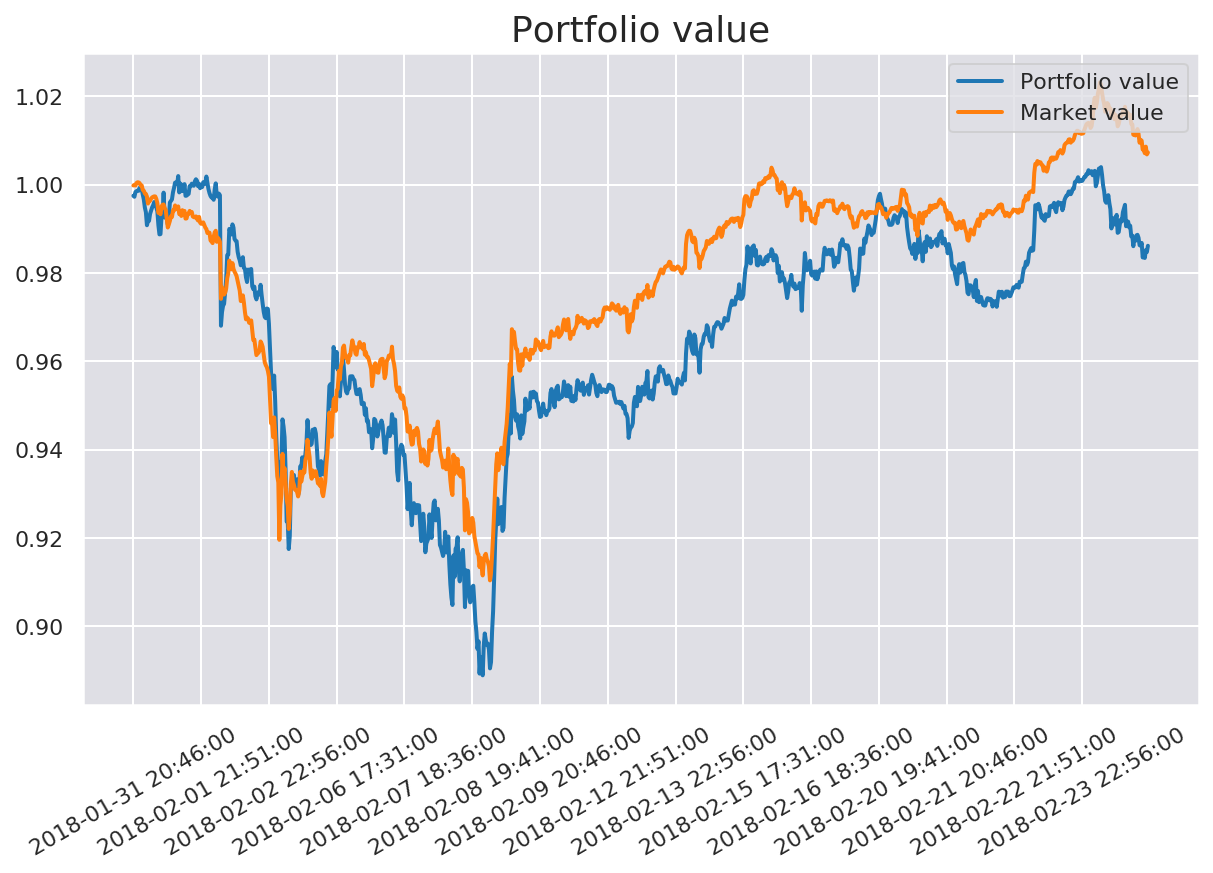

In [0]:
env_Feb = PortfolioEnv(history_Feb, abbreviation, steps=history_Feb.shape[1]-200, window_length=window_length,
                   start_idx=data['Feb'].date_index.iloc[0])
test_model(env_Feb, ddpg_model)

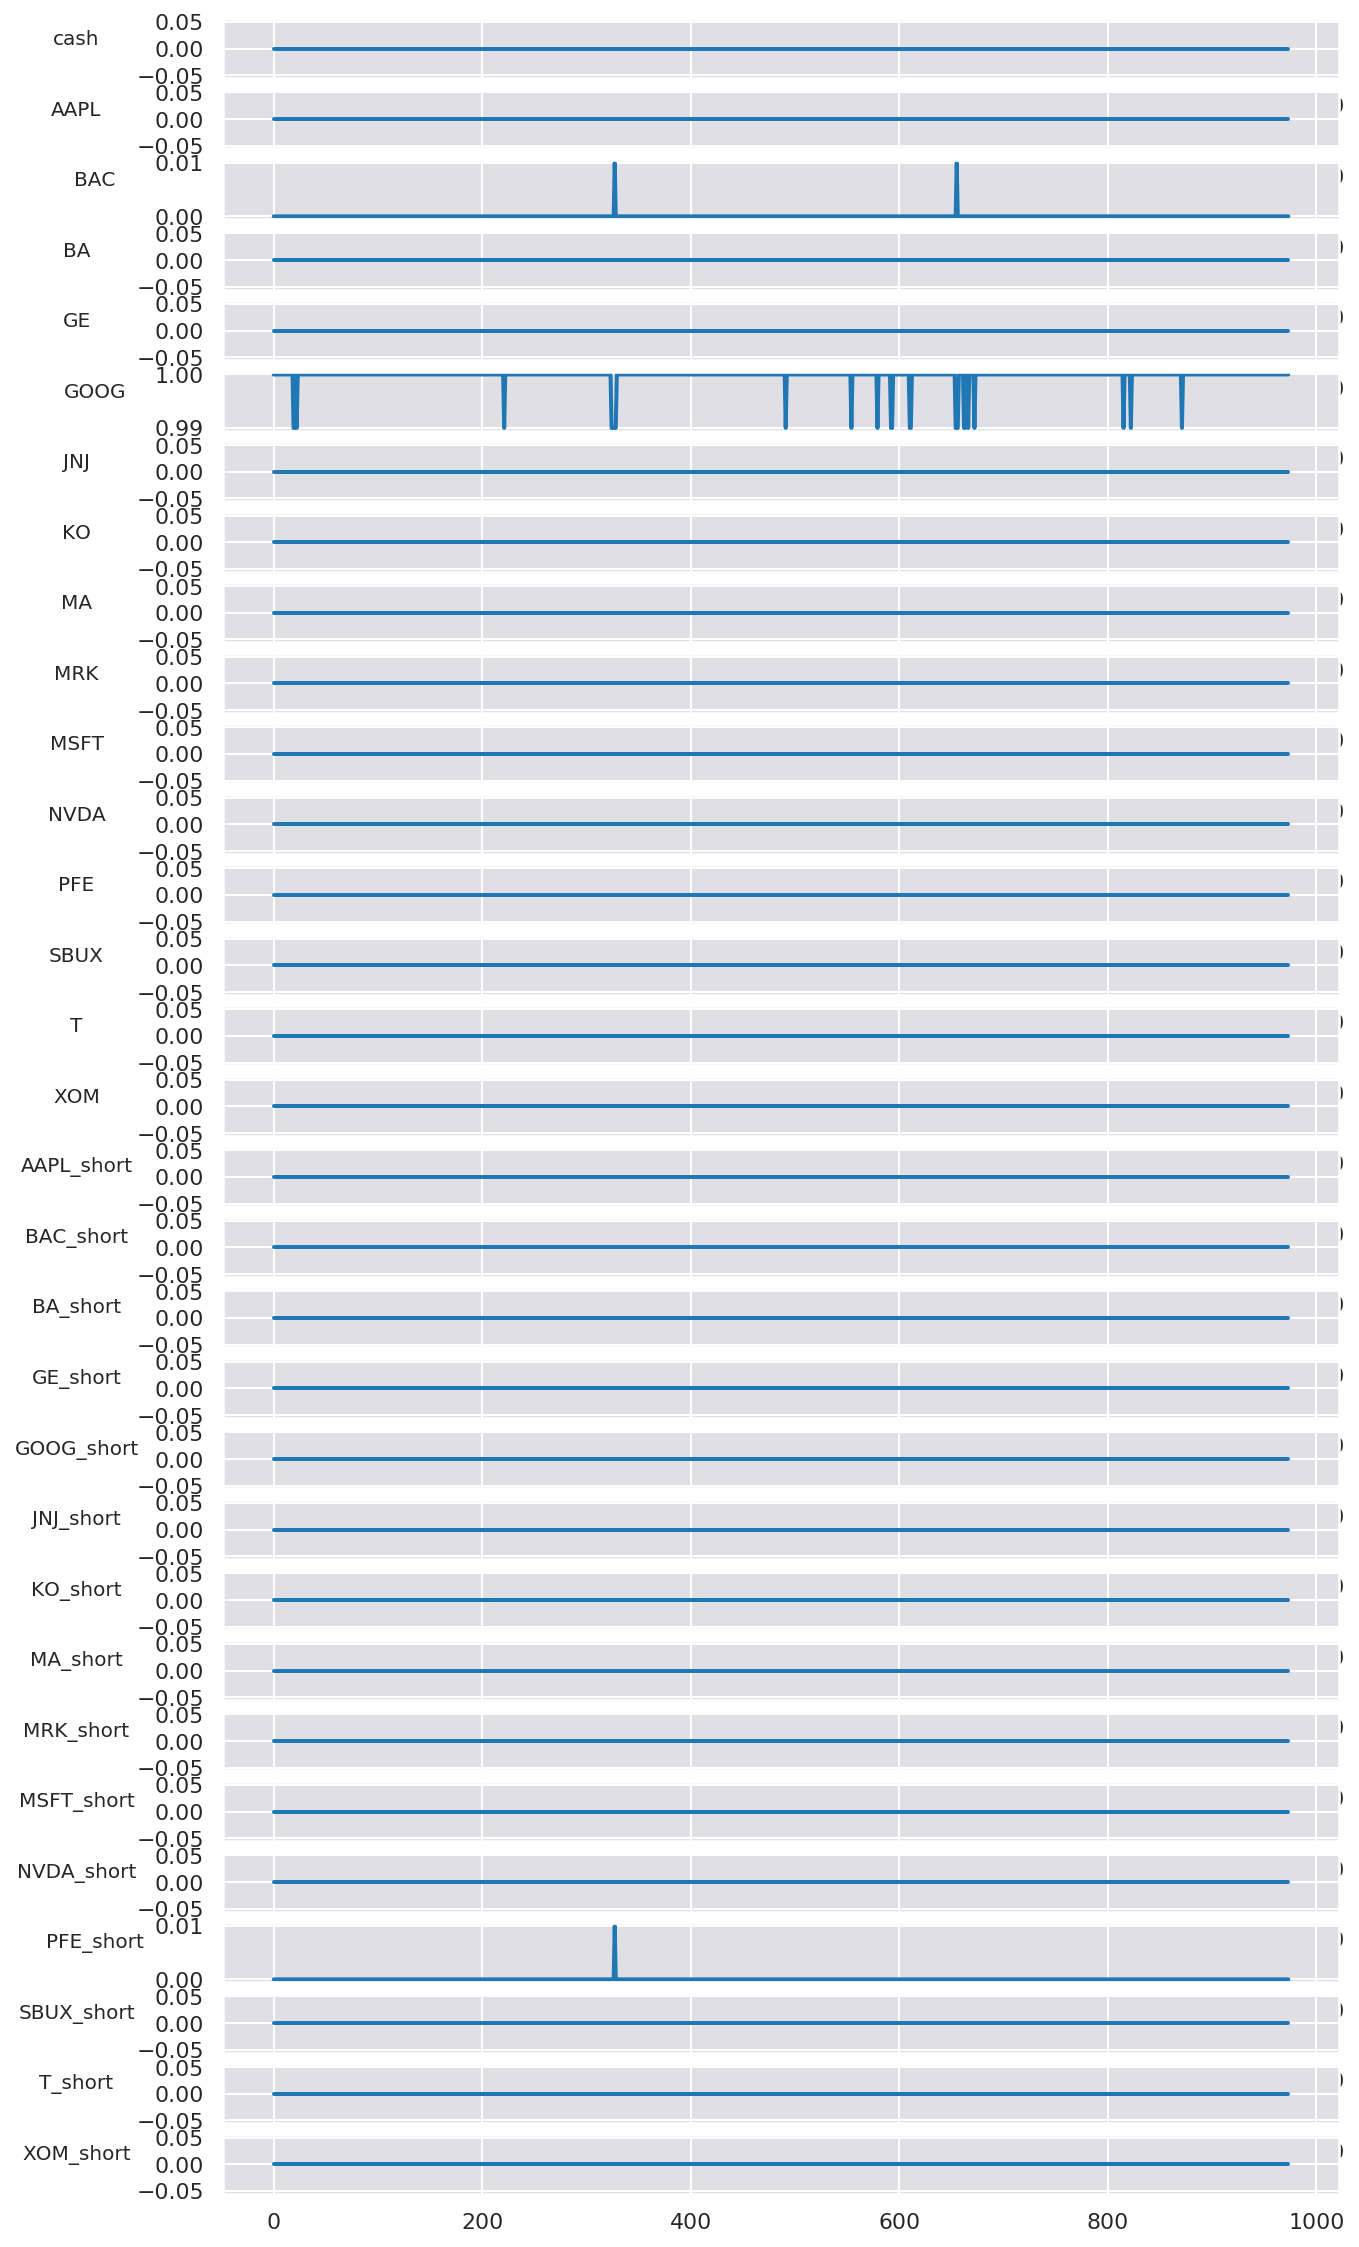

In [0]:
def plot_weights(env_infos):
    weights_change = np.empty((31,len(env_infos)))
    for i in range(len(env_infos)):
        weights_change[:, i] = env_infos[i]['weights']
    long_position = list(abbreviation.iloc[:, 0])
    short_position = []
    for i in long_position:
        short_position.append(i + '_short')
    ylabel = ['cash'] + long_position + short_position
    plt.figure(figsize=(10,20))
    for i in range(31):
        plt.subplot(31, 1, i+1)
        plt.plot(np.round(weights_change[i, :], decimals=2))
        h = plt.ylabel(ylabel[i], fontsize = 10, labelpad=30)
        h.set_rotation(0)
plot_weights(env_Feb.infos)

Build model from scratch
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'
1500
[0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03
 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03
 0.03 0.03 0.03]
[0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03
 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03
 0.03 0.03 0.03]
Episode: 0, Reward: 1.00, Qmax: 0.0000
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'
Type is unsupported, or the types of the items don't match field ty

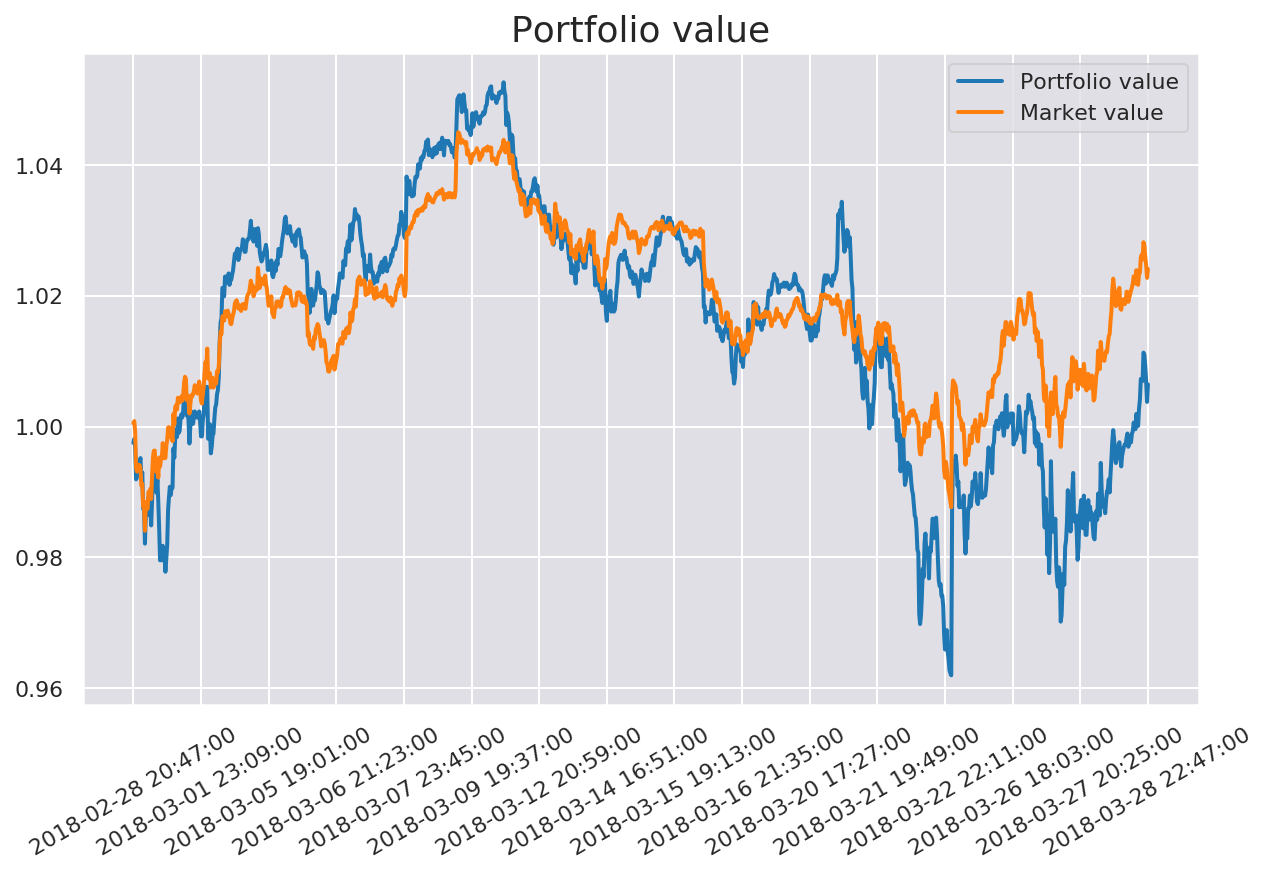

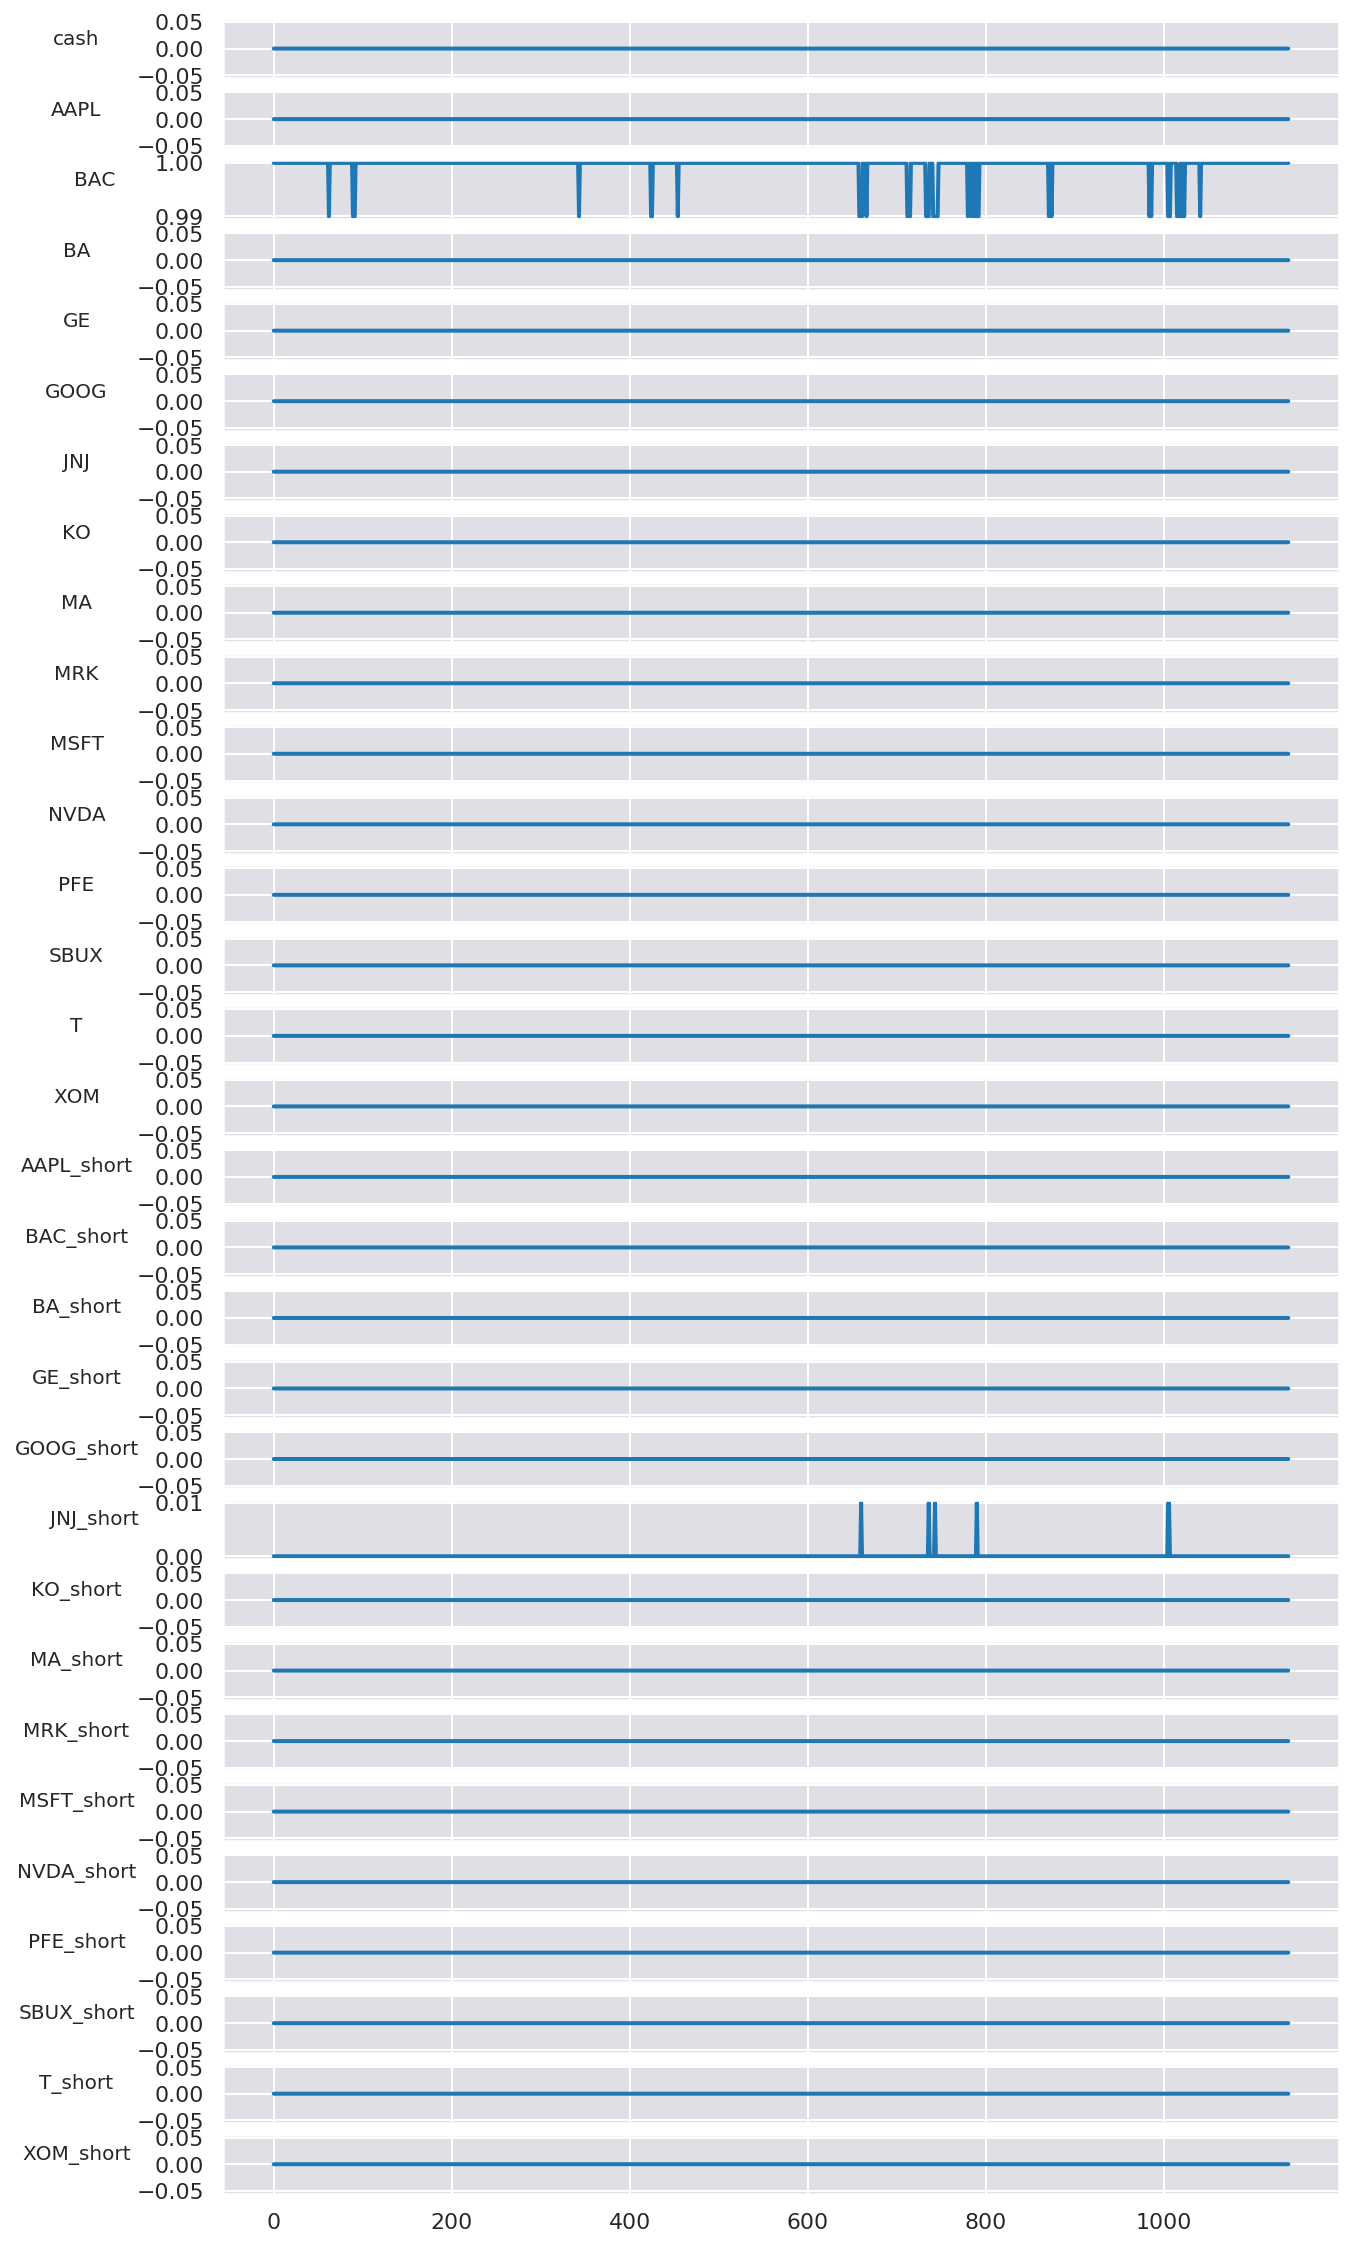

In [0]:
tf.reset_default_graph()
sess = tf.Session()
tflearn.config.init_training_mode()
action_dim = [nb_classes*2 + 1]
state_dim = [nb_classes + 1, window_length, 3]
variable_scope = get_variable_scope(window_length, predictor_type, use_batch_norm)
with tf.variable_scope(variable_scope):
    actor = StockActor(sess, state_dim, action_dim, action_bound, 1e-4, tau, batch_size, predictor_type, 
                       use_batch_norm)
    critic = StockCritic(sess=sess, state_dim=state_dim, action_dim=action_dim, tau=1e-3,
                         learning_rate=1e-3, num_actor_vars=actor.get_num_trainable_vars(), 
                         predictor_type=predictor_type, use_batch_norm=use_batch_norm)
    actor_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(action_dim))

    model_save_path = "weights/"
    summary_path = get_result_path(window_length, predictor_type, use_batch_norm)

    ddpg_model = DDPG(environ, sess, actor, critic, actor_noise, param, obs_normalizer=obs_normalizer,
                      model_save_path=model_save_path,
                      summary_path=summary_path)
    ddpg_model.initialize(load_weights=False, verbose=False)
    ddpg_model.train()

env_Mar = PortfolioEnv(history_Mar, abbreviation, steps=history_Mar.shape[1]-200, window_length=window_length,
                   start_idx=data['Mar'].date_index.iloc[0])
test_model(env_Mar, ddpg_model)
plot_weights(env_Mar.infos)

INFO:tensorflow:Restoring parameters from weights/stock/lstm/window_30/batch_norm/Model_Mar/checkpoint.ckpt_Episode_1500/checkpoint.ckpt


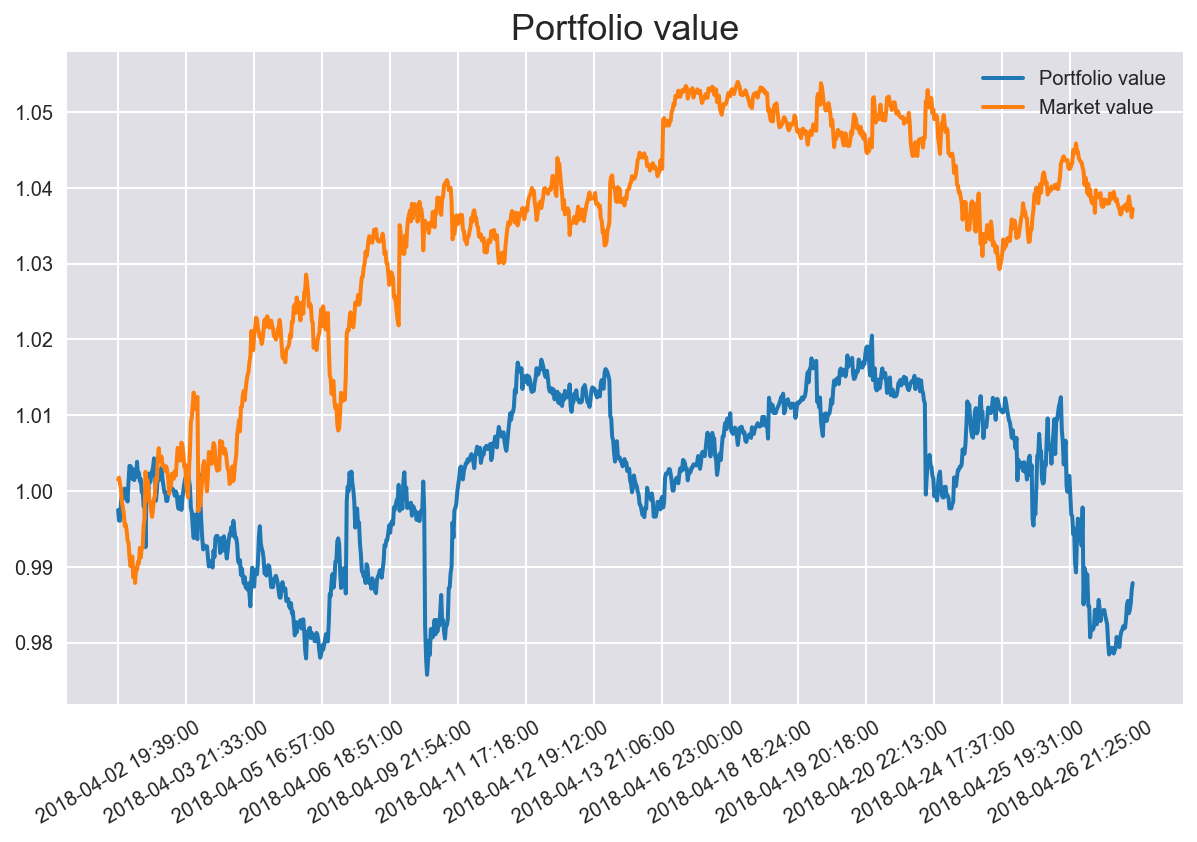

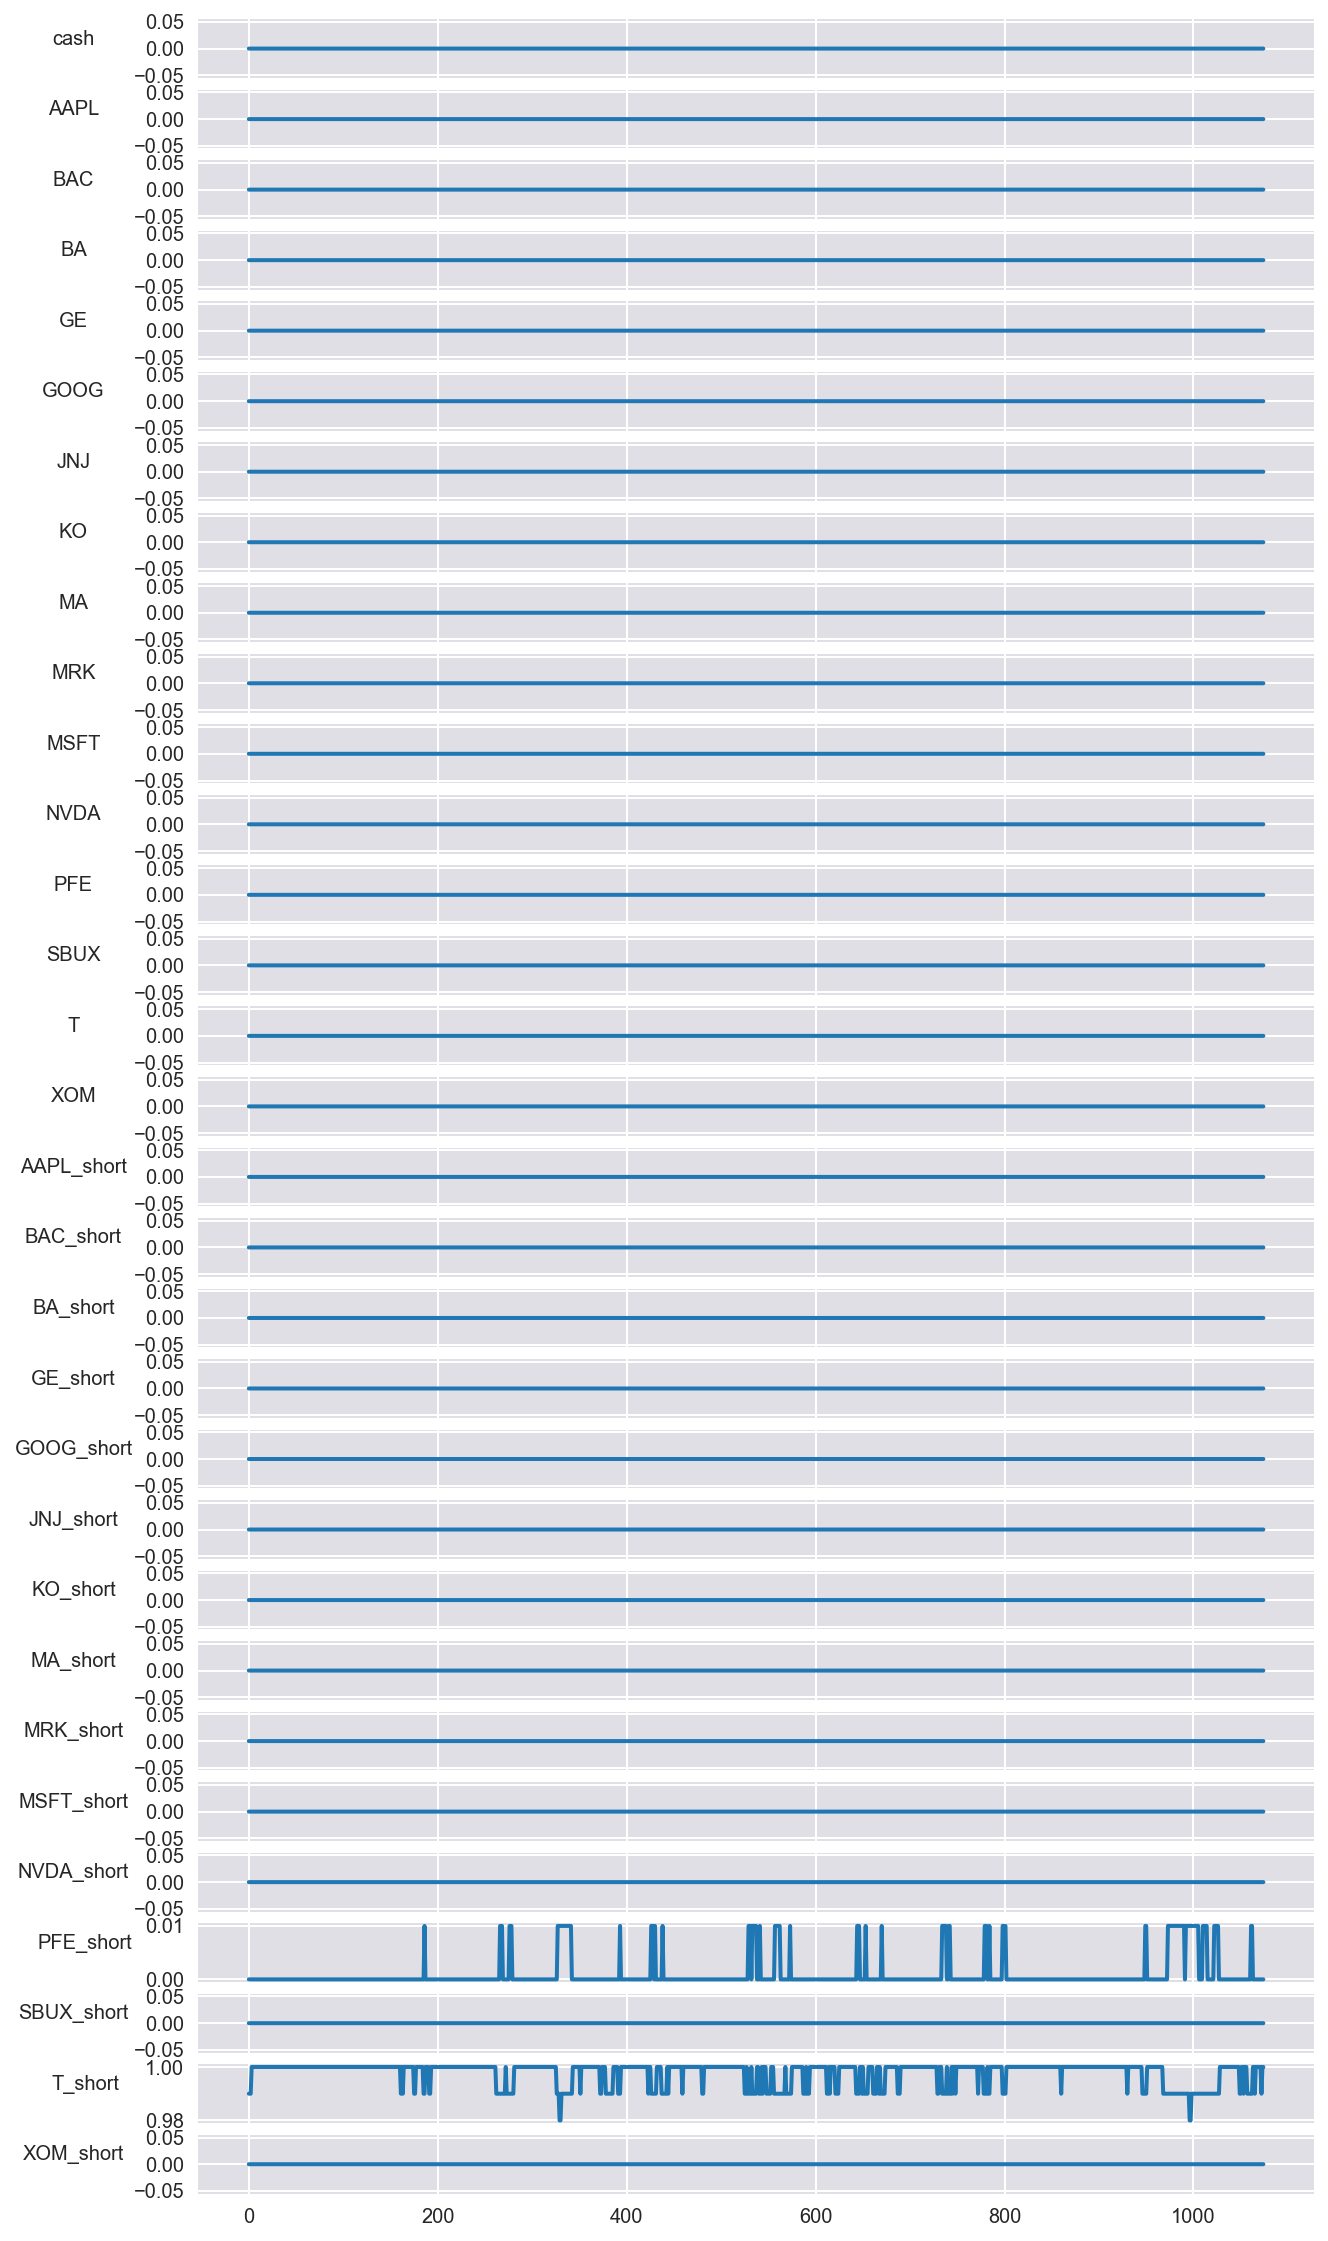

In [0]:
tf.reset_default_graph()
sess = tf.Session()
tflearn.config.init_training_mode()
action_dim = [nb_classes*2 + 1]
state_dim = [nb_classes + 1, window_length, 3]
variable_scope = get_variable_scope(window_length, predictor_type, use_batch_norm)
with tf.variable_scope(variable_scope):
    actor = StockActor(sess, state_dim, action_dim, action_bound, 1e-4, tau, batch_size, predictor_type, 
                       use_batch_norm)
    critic = StockCritic(sess=sess, state_dim=state_dim, action_dim=action_dim, tau=1e-3,
                         learning_rate=1e-3, num_actor_vars=actor.get_num_trainable_vars(), 
                         predictor_type=predictor_type, use_batch_norm=use_batch_norm)
    actor_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(action_dim))

    model_save_path = "weights/"
    summary_path = get_result_path(window_length, predictor_type, use_batch_norm)

    ddpg_model = DDPG(environ, sess, actor, critic, actor_noise, param, obs_normalizer=obs_normalizer,
                       model_save_path=model_save_path,
                      summary_path=summary_path)
    ddpg_model.initialize(load_weights=False, verbose=False)
    ddpg_model.train()

env_Apr = PortfolioEnv(history_Apr, abbreviation, steps=history_Apr.shape[1]-200, window_length=window_length,
                   start_idx=data['Apr'].date_index.iloc[0])
test_model(env_Apr, ddpg_model)
plot_weights(env_Apr.infos)

INFO:tensorflow:Restoring parameters from weights/stock/lstm/window_30/batch_norm/Model_Apr/checkpoint.ckpt_Episode_1500/checkpoint.ckpt


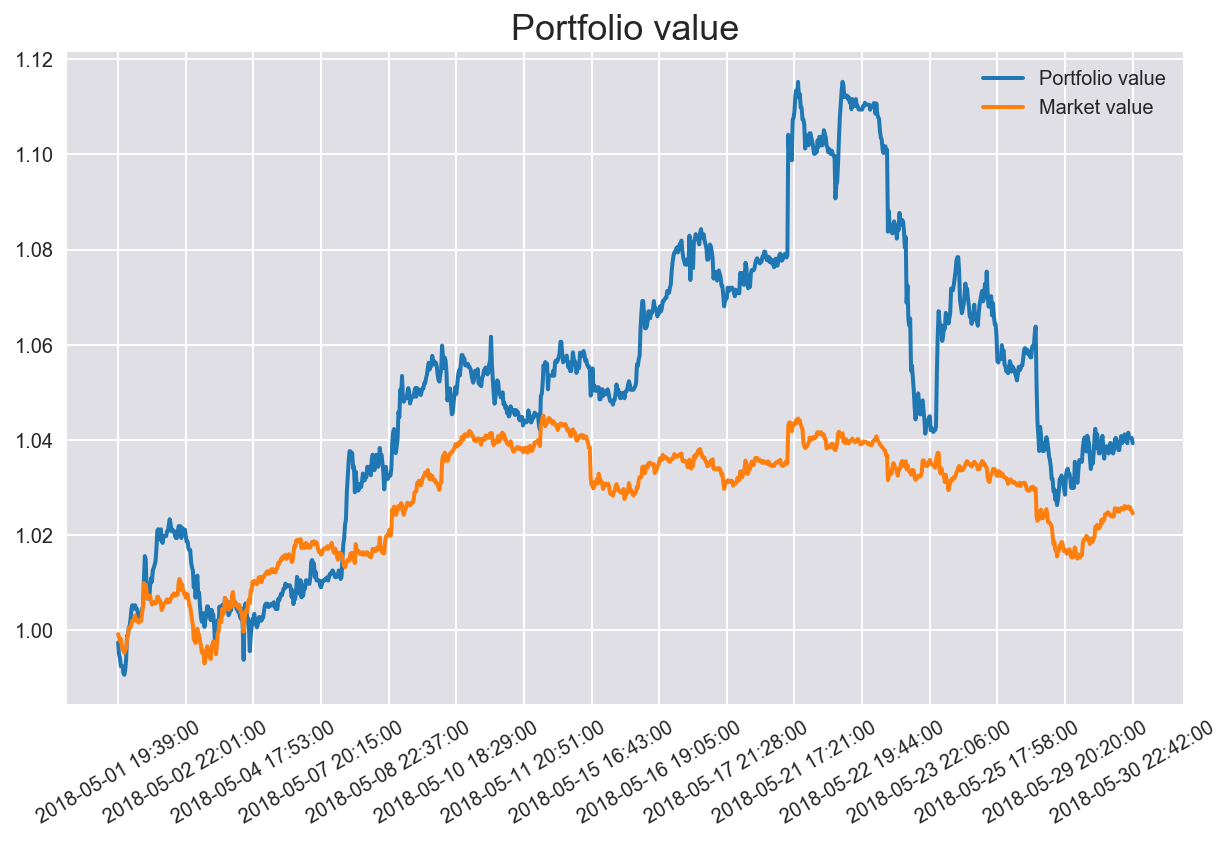

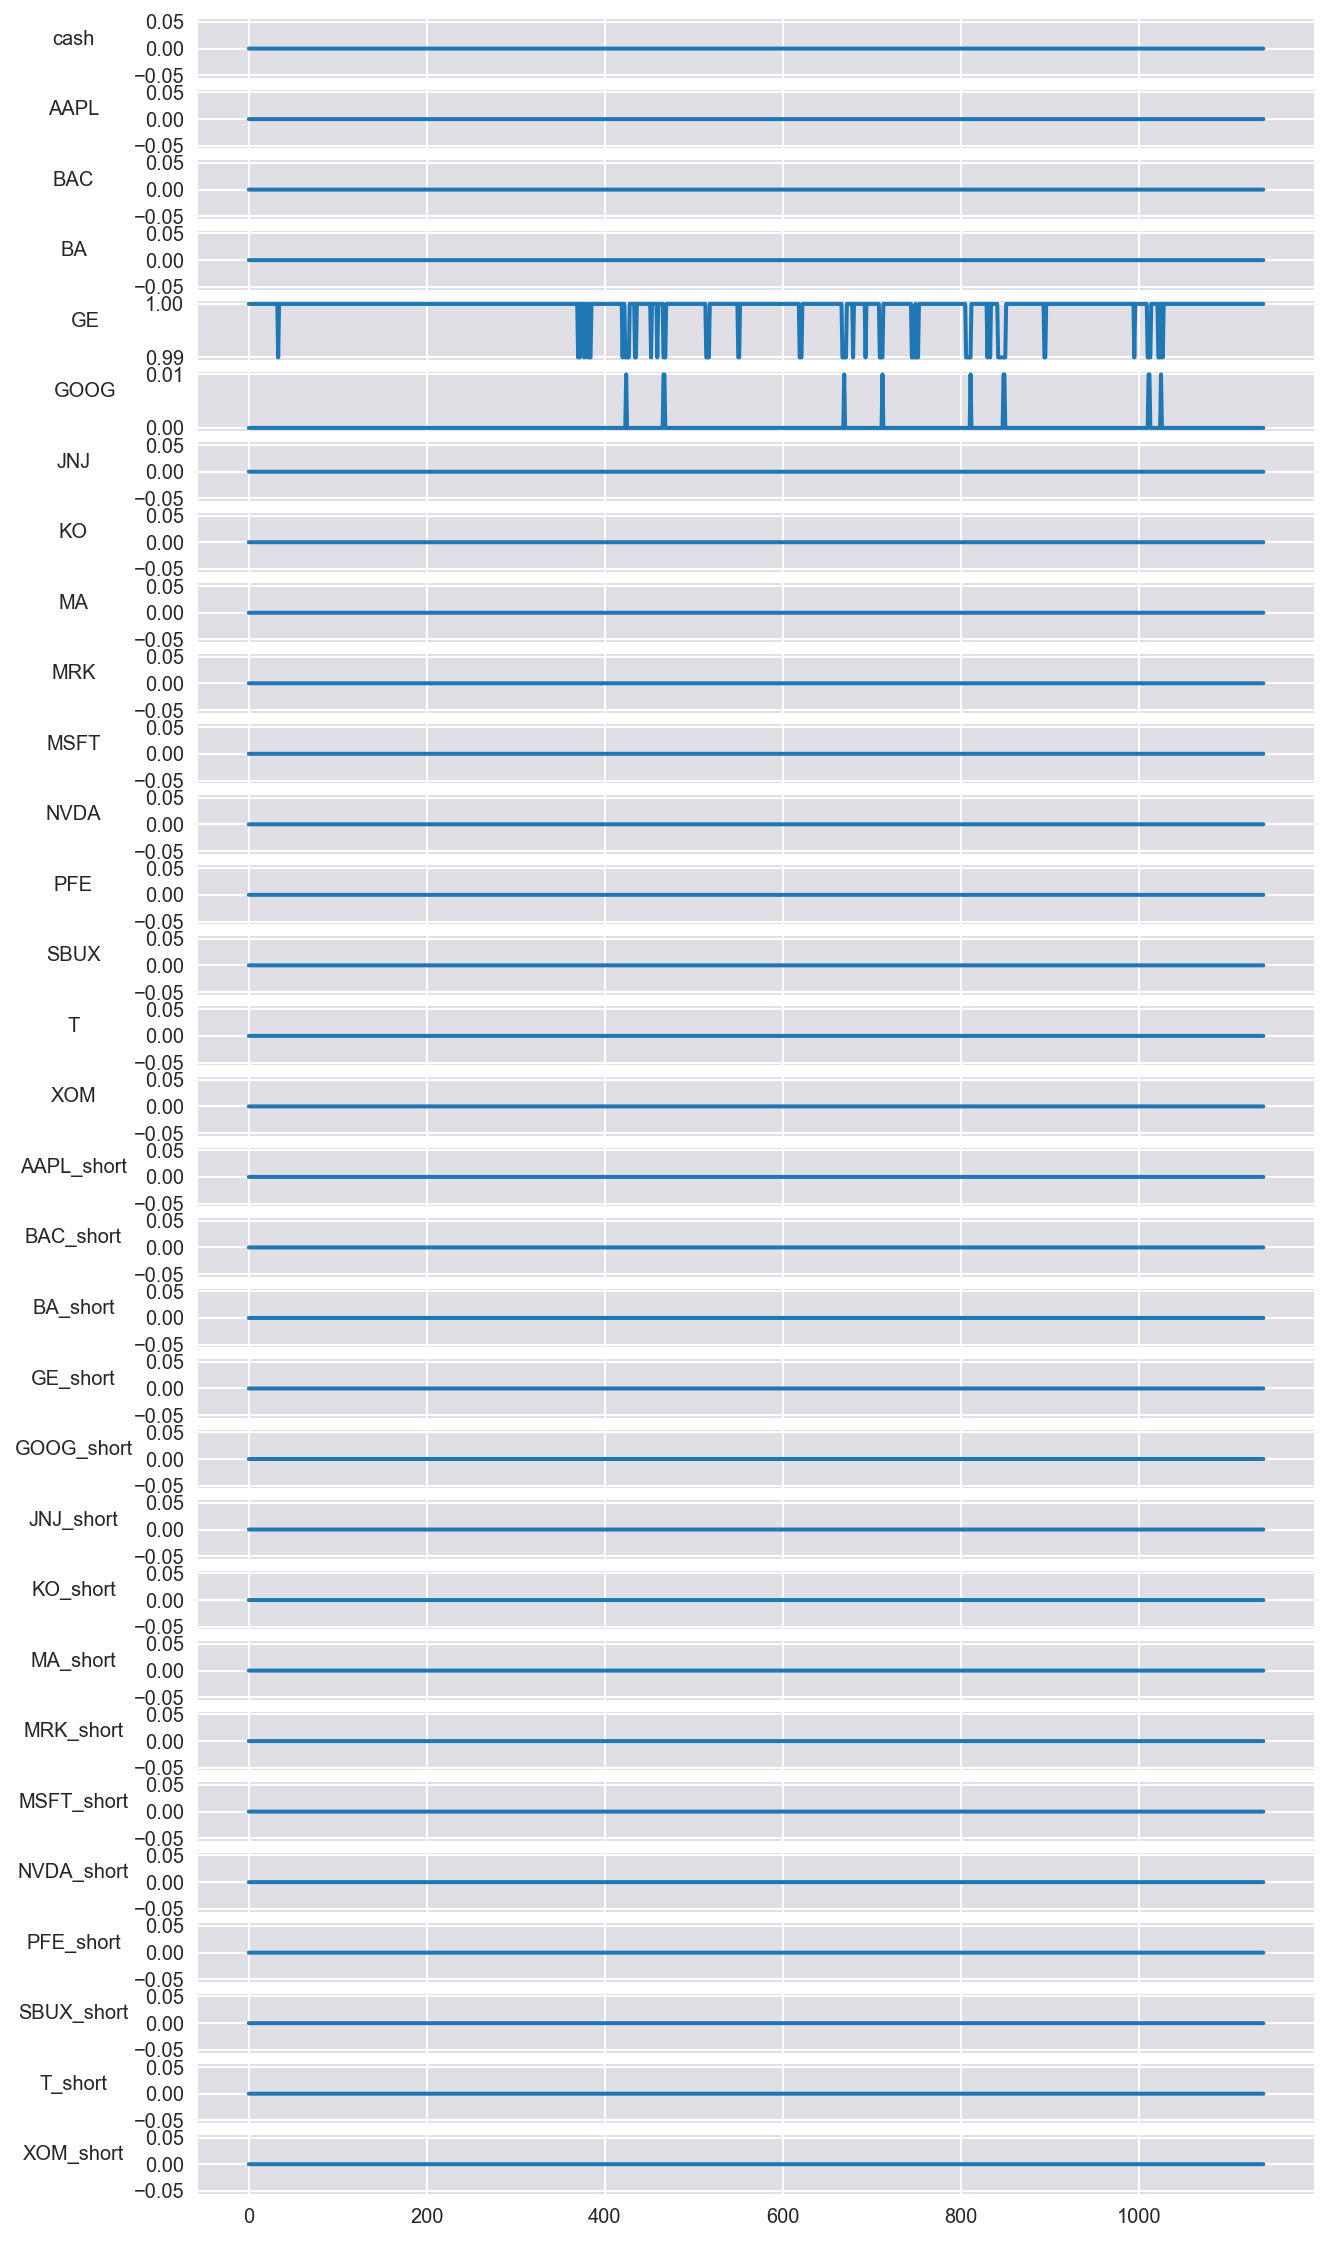

In [0]:
tf.reset_default_graph()
sess = tf.Session()
tflearn.config.init_training_mode()
action_dim = [nb_classes*2 + 1]
state_dim = [nb_classes + 1, window_length, 3]
variable_scope = get_variable_scope(window_length, predictor_type, use_batch_norm)
with tf.variable_scope(variable_scope):
    actor = StockActor(sess, state_dim, action_dim, action_bound, 1e-4, tau, batch_size, predictor_type, 
                       use_batch_norm)
    critic = StockCritic(sess=sess, state_dim=state_dim, action_dim=action_dim, tau=1e-3,
                         learning_rate=1e-3, num_actor_vars=actor.get_num_trainable_vars(), 
                         predictor_type=predictor_type, use_batch_norm=use_batch_norm)
    actor_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(action_dim))

    model_save_path = "weights/"
    summary_path = get_result_path(window_length, predictor_type, use_batch_norm)

    ddpg_model = DDPG(environ, sess, actor, critic, actor_noise,param, obs_normalizer=obs_normalizer, model_save_path=model_save_path,
                      summary_path=summary_path)
    ddpg_model.initialize(load_weights=False, verbose=False)
    ddpg_model.train()

env_May = PortfolioEnv(history_May, abbreviation, steps=history_May.shape[1]-200, window_length=window_length,
                   start_idx=data['May'].date_index.iloc[0])
test_model(env_May, ddpg_model)
plot_weights(env_May.infos)

INFO:tensorflow:Restoring parameters from weights/stock/lstm/window_30/batch_norm/Model_May/checkpoint.ckpt_Episode_1500/checkpoint.ckpt


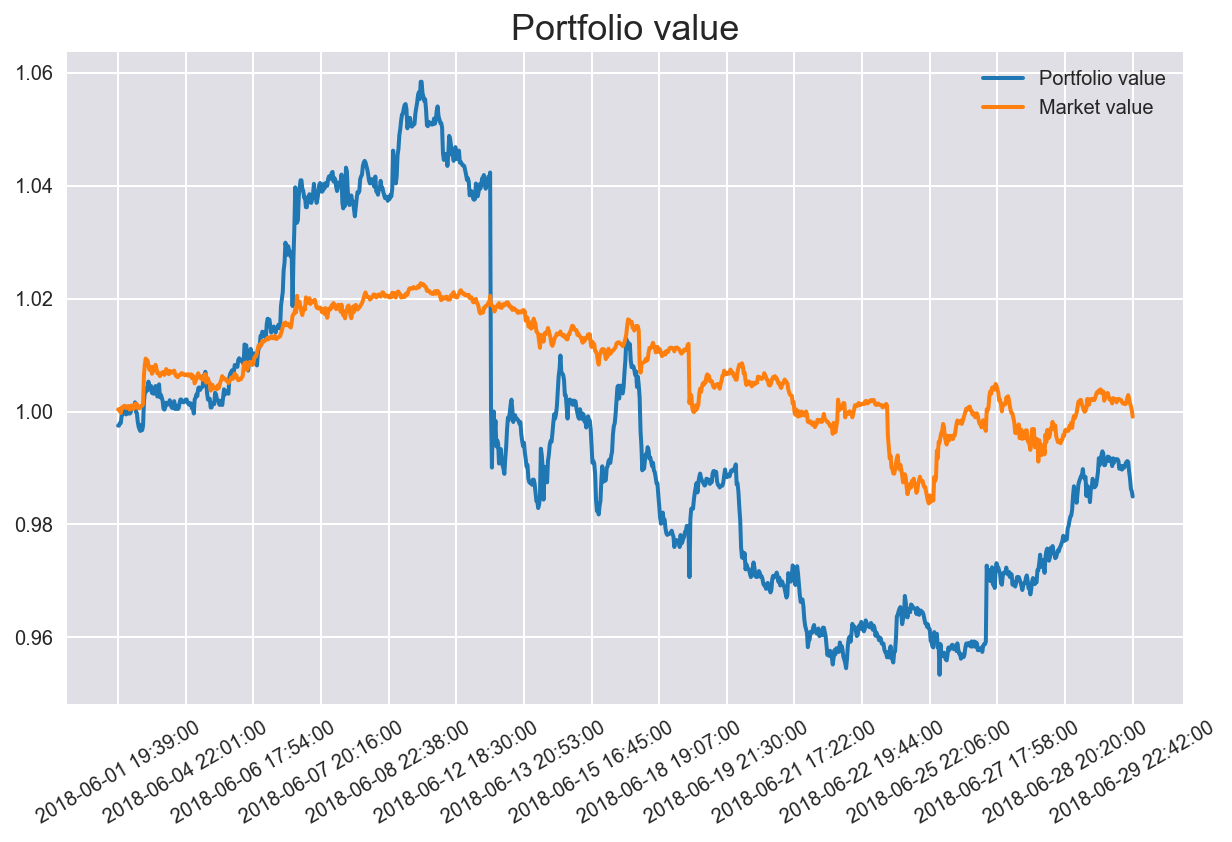

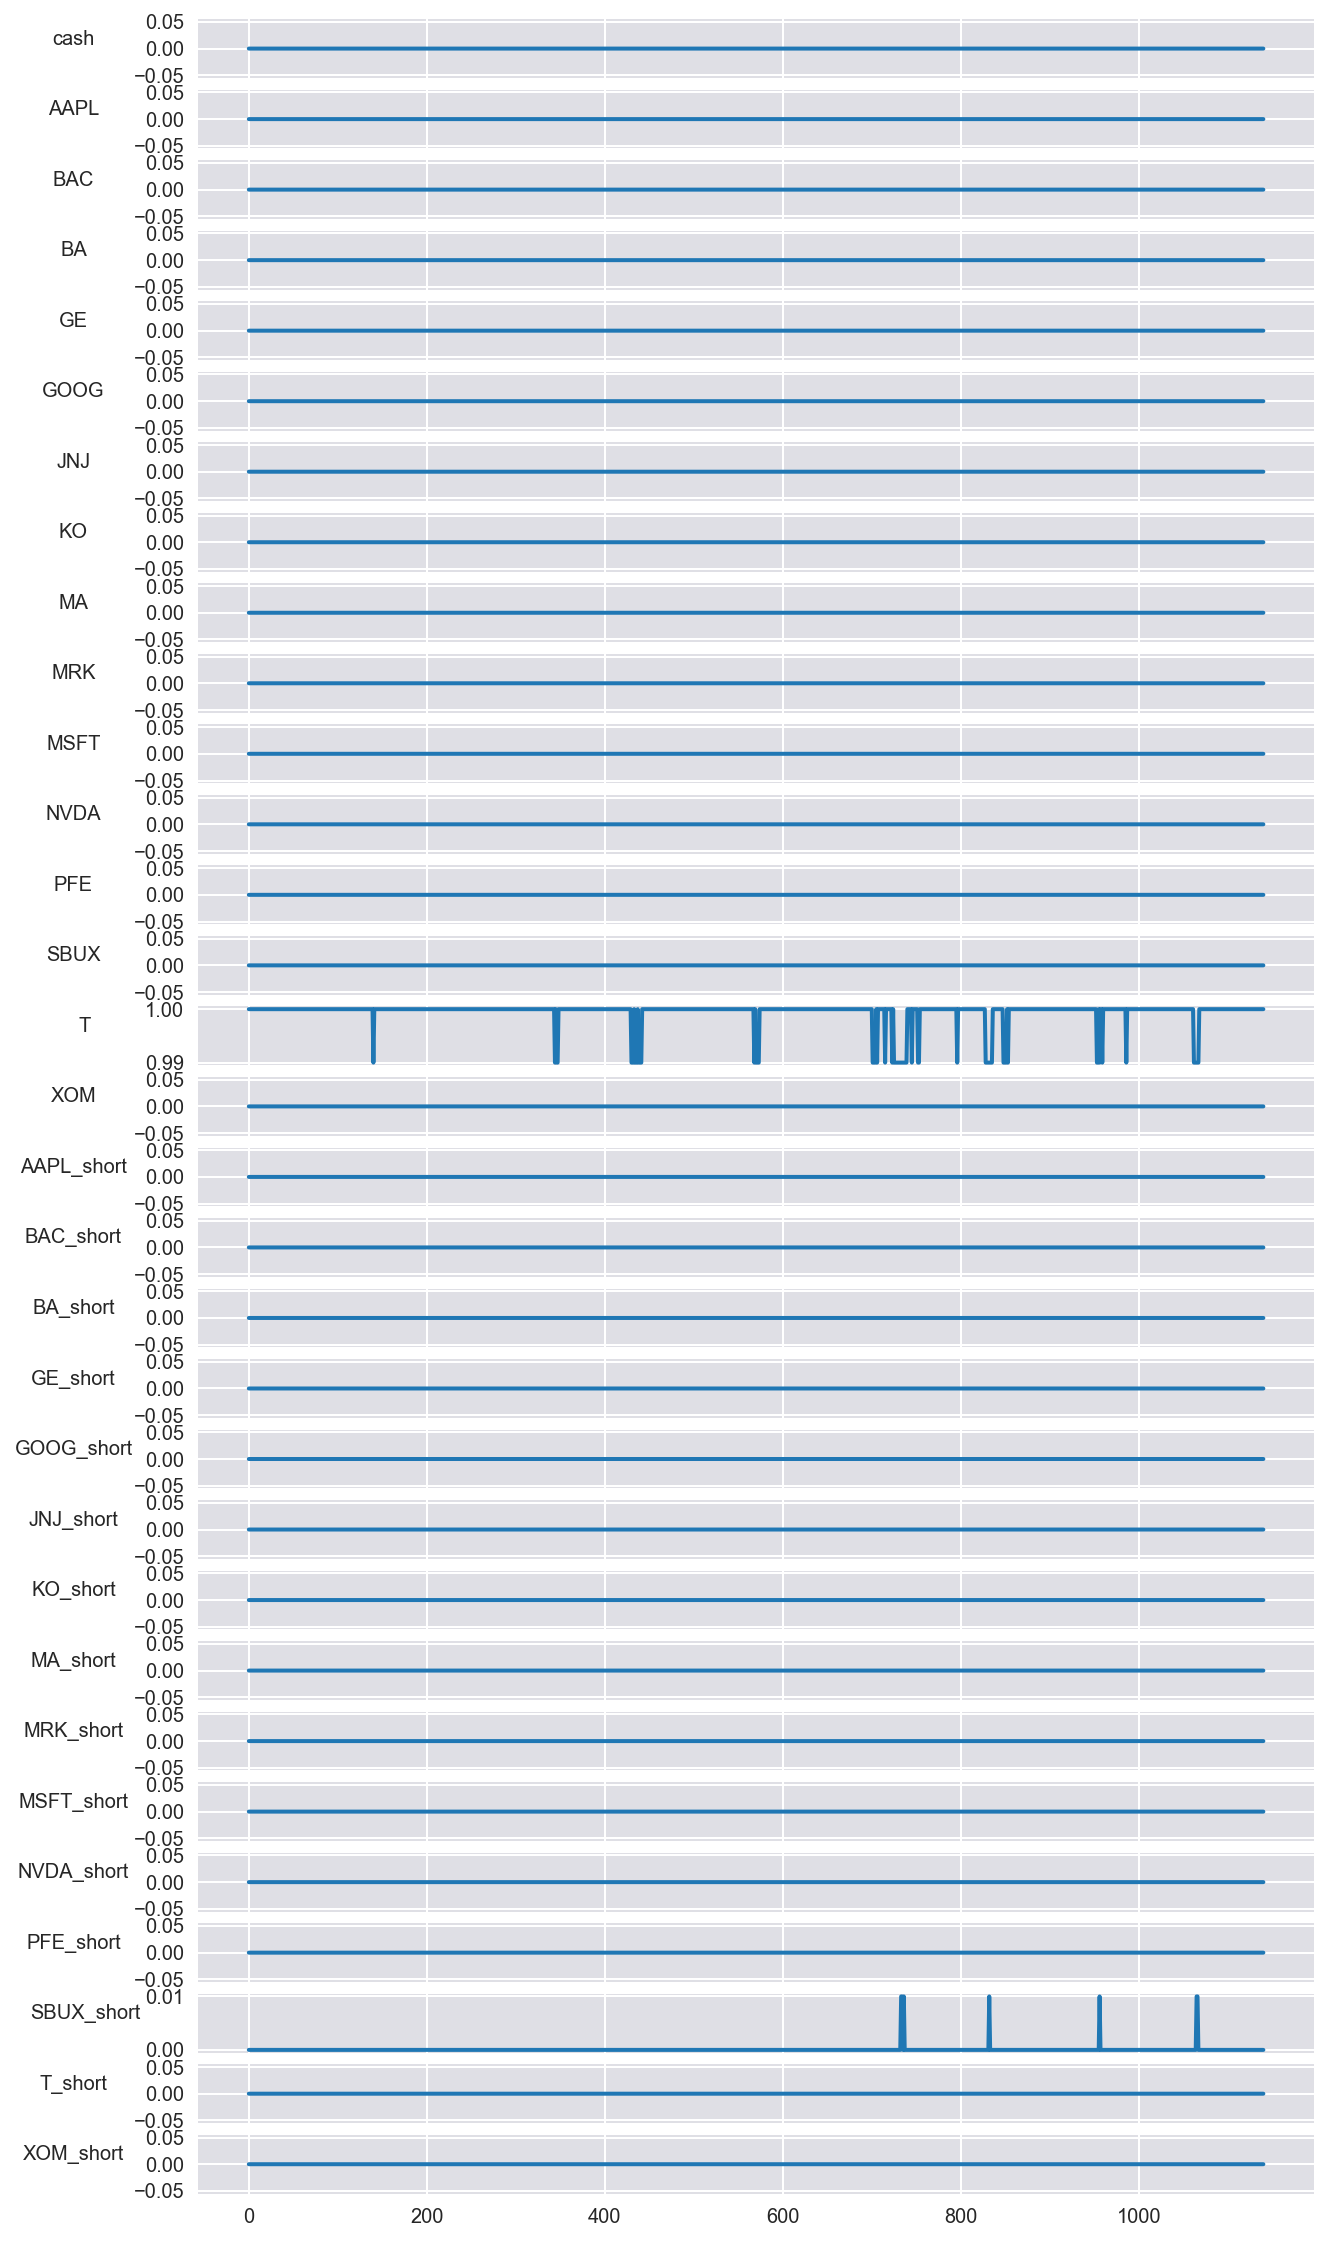

In [0]:
tf.reset_default_graph()
sess = tf.Session()
tflearn.config.init_training_mode()
action_dim = [nb_classes*2 + 1]
state_dim = [nb_classes + 1, window_length, 3]
variable_scope = get_variable_scope(window_length, predictor_type, use_batch_norm)
with tf.variable_scope(variable_scope):
    actor = StockActor(sess, state_dim, action_dim, action_bound, 1e-4, tau, batch_size, predictor_type, 
                       use_batch_norm)
    critic = StockCritic(sess=sess, state_dim=state_dim, action_dim=action_dim, tau=1e-3,
                         learning_rate=1e-3, num_actor_vars=actor.get_num_trainable_vars(), 
                         predictor_type=predictor_type, use_batch_norm=use_batch_norm)
    actor_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(action_dim))

    model_save_path = "weights/"
    summary_path = get_result_path(window_length, predictor_type, use_batch_norm)

    ddpg_model = DDPG(environ, sess, actor, critic, actor_noise,param, obs_normalizer=obs_normalizer, model_save_path=model_save_path,
                      summary_path=summary_path)
    ddpg_model.initialize(load_weights=False, verbose=False)
    ddpg_model.train()
    
env_Jun = PortfolioEnv(history_Jun, abbreviation, steps=history_Jun.shape[1]-200, window_length=window_length,
                   start_idx=data['Jun'].date_index.iloc[0])
test_model(env_Jun, ddpg_model)
plot_weights(env_Jun.infos)

INFO:tensorflow:Restoring parameters from weights/stock/lstm/window_30/batch_norm/Model_Jun/checkpoint.ckpt_Episode_1500/checkpoint.ckpt


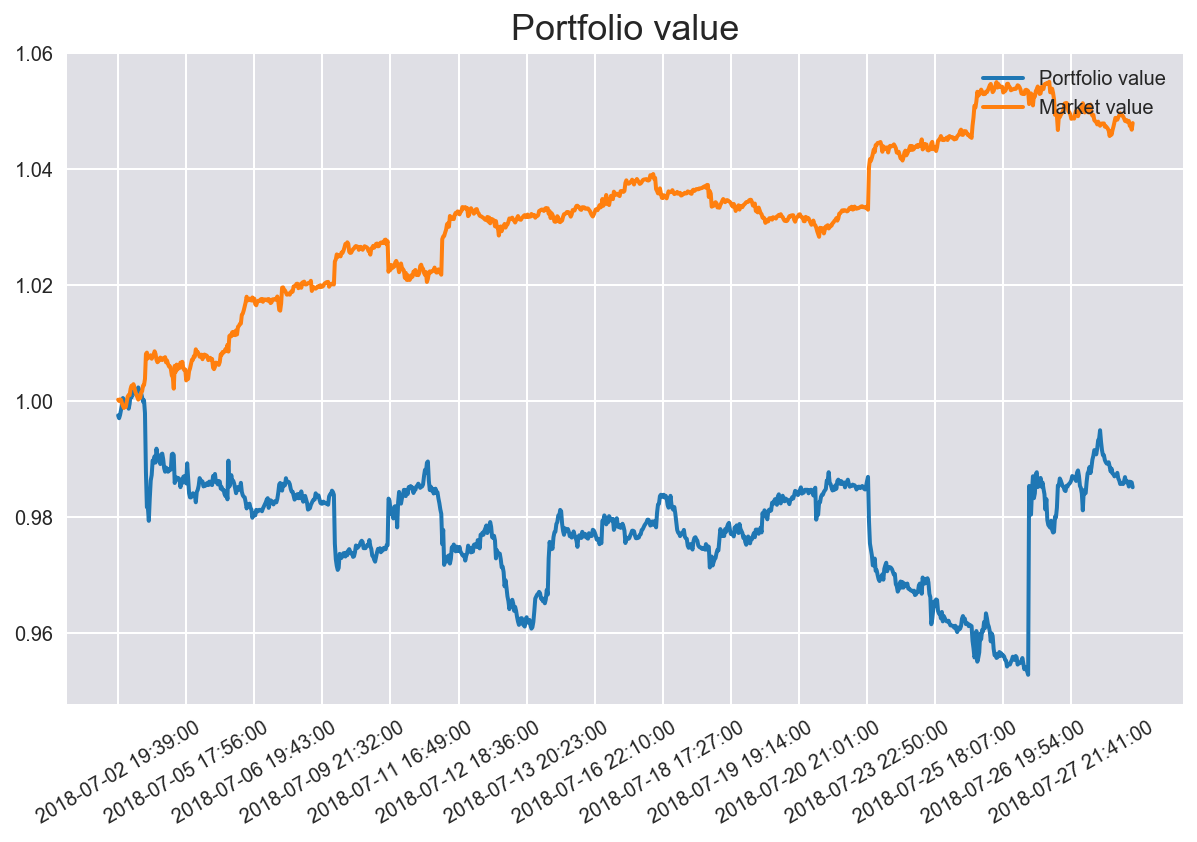

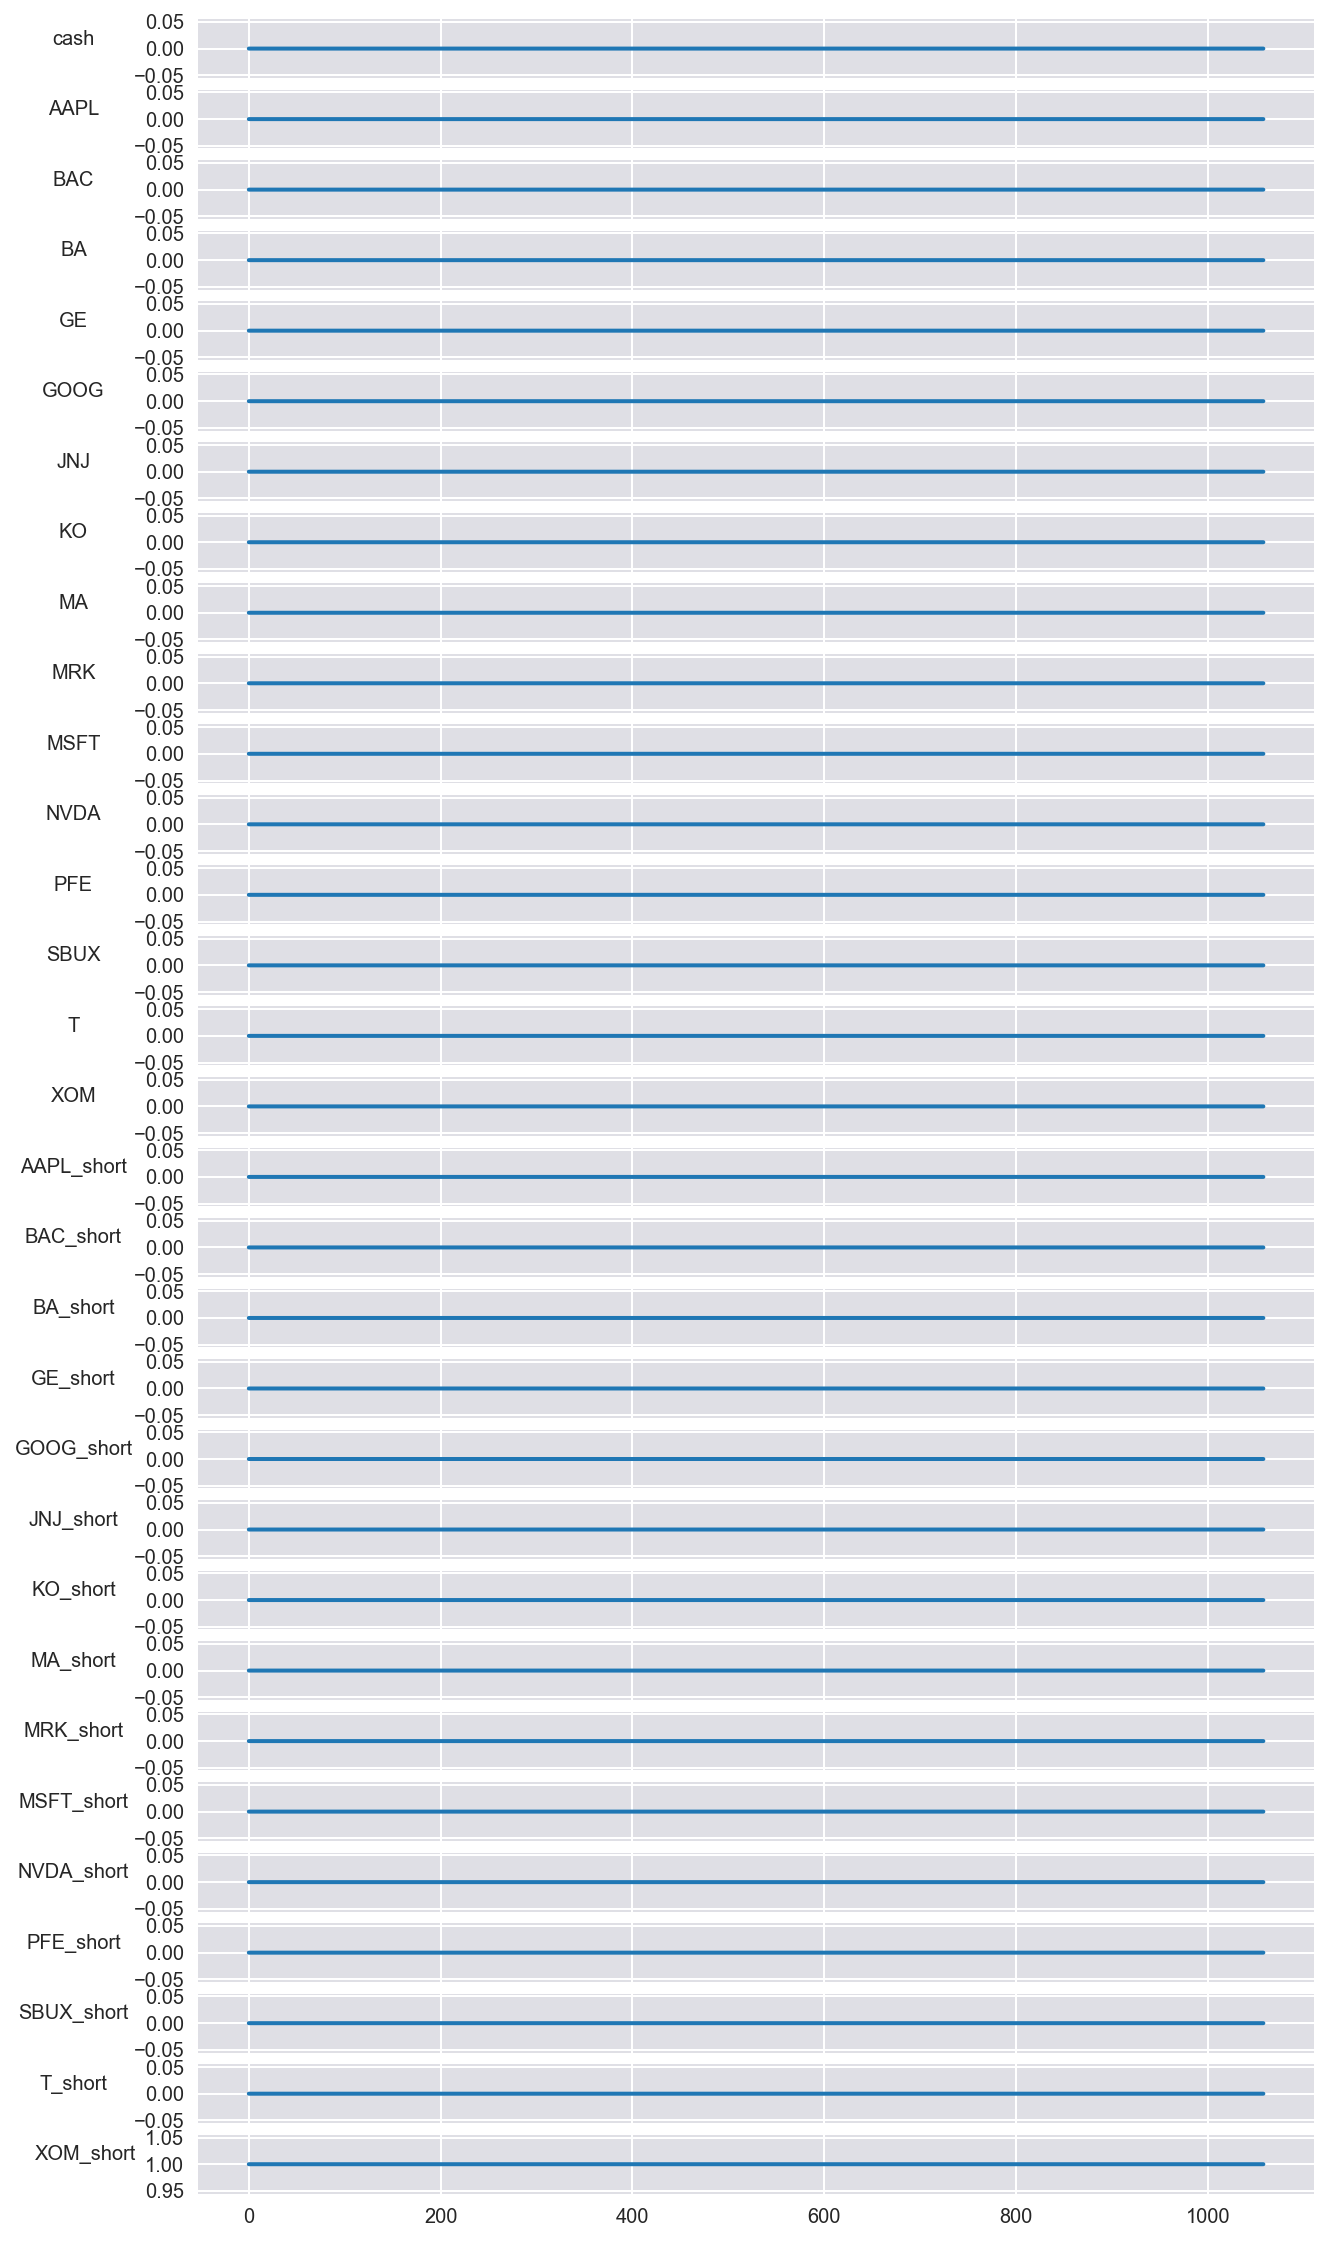

In [0]:
tf.reset_default_graph()
sess = tf.Session()
tflearn.config.init_training_mode()
action_dim = [nb_classes*2 + 1]
state_dim = [nb_classes + 1, window_length, 3]
variable_scope = get_variable_scope(window_length, predictor_type, use_batch_norm)
with tf.variable_scope(variable_scope):
    actor = StockActor(sess, state_dim, action_dim, action_bound, 1e-4, tau, batch_size, predictor_type, 
                       use_batch_norm)
    critic = StockCritic(sess=sess, state_dim=state_dim, action_dim=action_dim, tau=1e-3,
                         learning_rate=1e-3, num_actor_vars=actor.get_num_trainable_vars(), 
                         predictor_type=predictor_type, use_batch_norm=use_batch_norm)
    actor_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(action_dim))

    model_save_path = "weights/"
    summary_path = get_result_path(window_length, predictor_type, use_batch_norm)

    ddpg_model = DDPG(environ, sess, actor, critic, actor_noise,param, obs_normalizer=obs_normalizer, model_save_path=model_save_path,
                      summary_path=summary_path)
    ddpg_model.initialize(load_weights=False, verbose=False)
    ddpg_model.train()

env_Jul = PortfolioEnv(history_Jul, abbreviation, steps=history_Jul.shape[1]-200, window_length=window_length,
                   start_idx=data['Jul'].date_index.iloc[0])
test_model(env_Jul, ddpg_model)
plot_weights(env_Jul.infos)

INFO:tensorflow:Restoring parameters from weights/stock/lstm/window_30/batch_norm/Model_Jul/checkpoint.ckpt_Episode_1500/checkpoint.ckpt


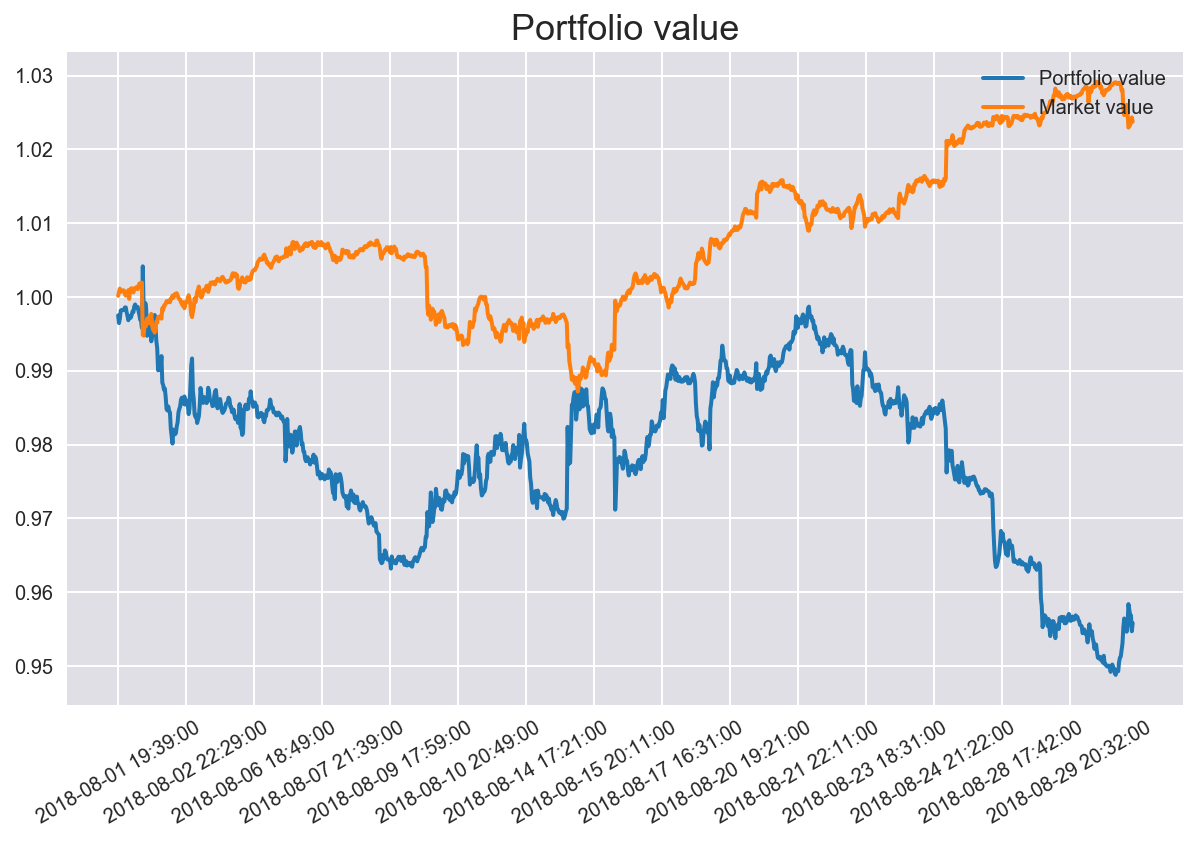

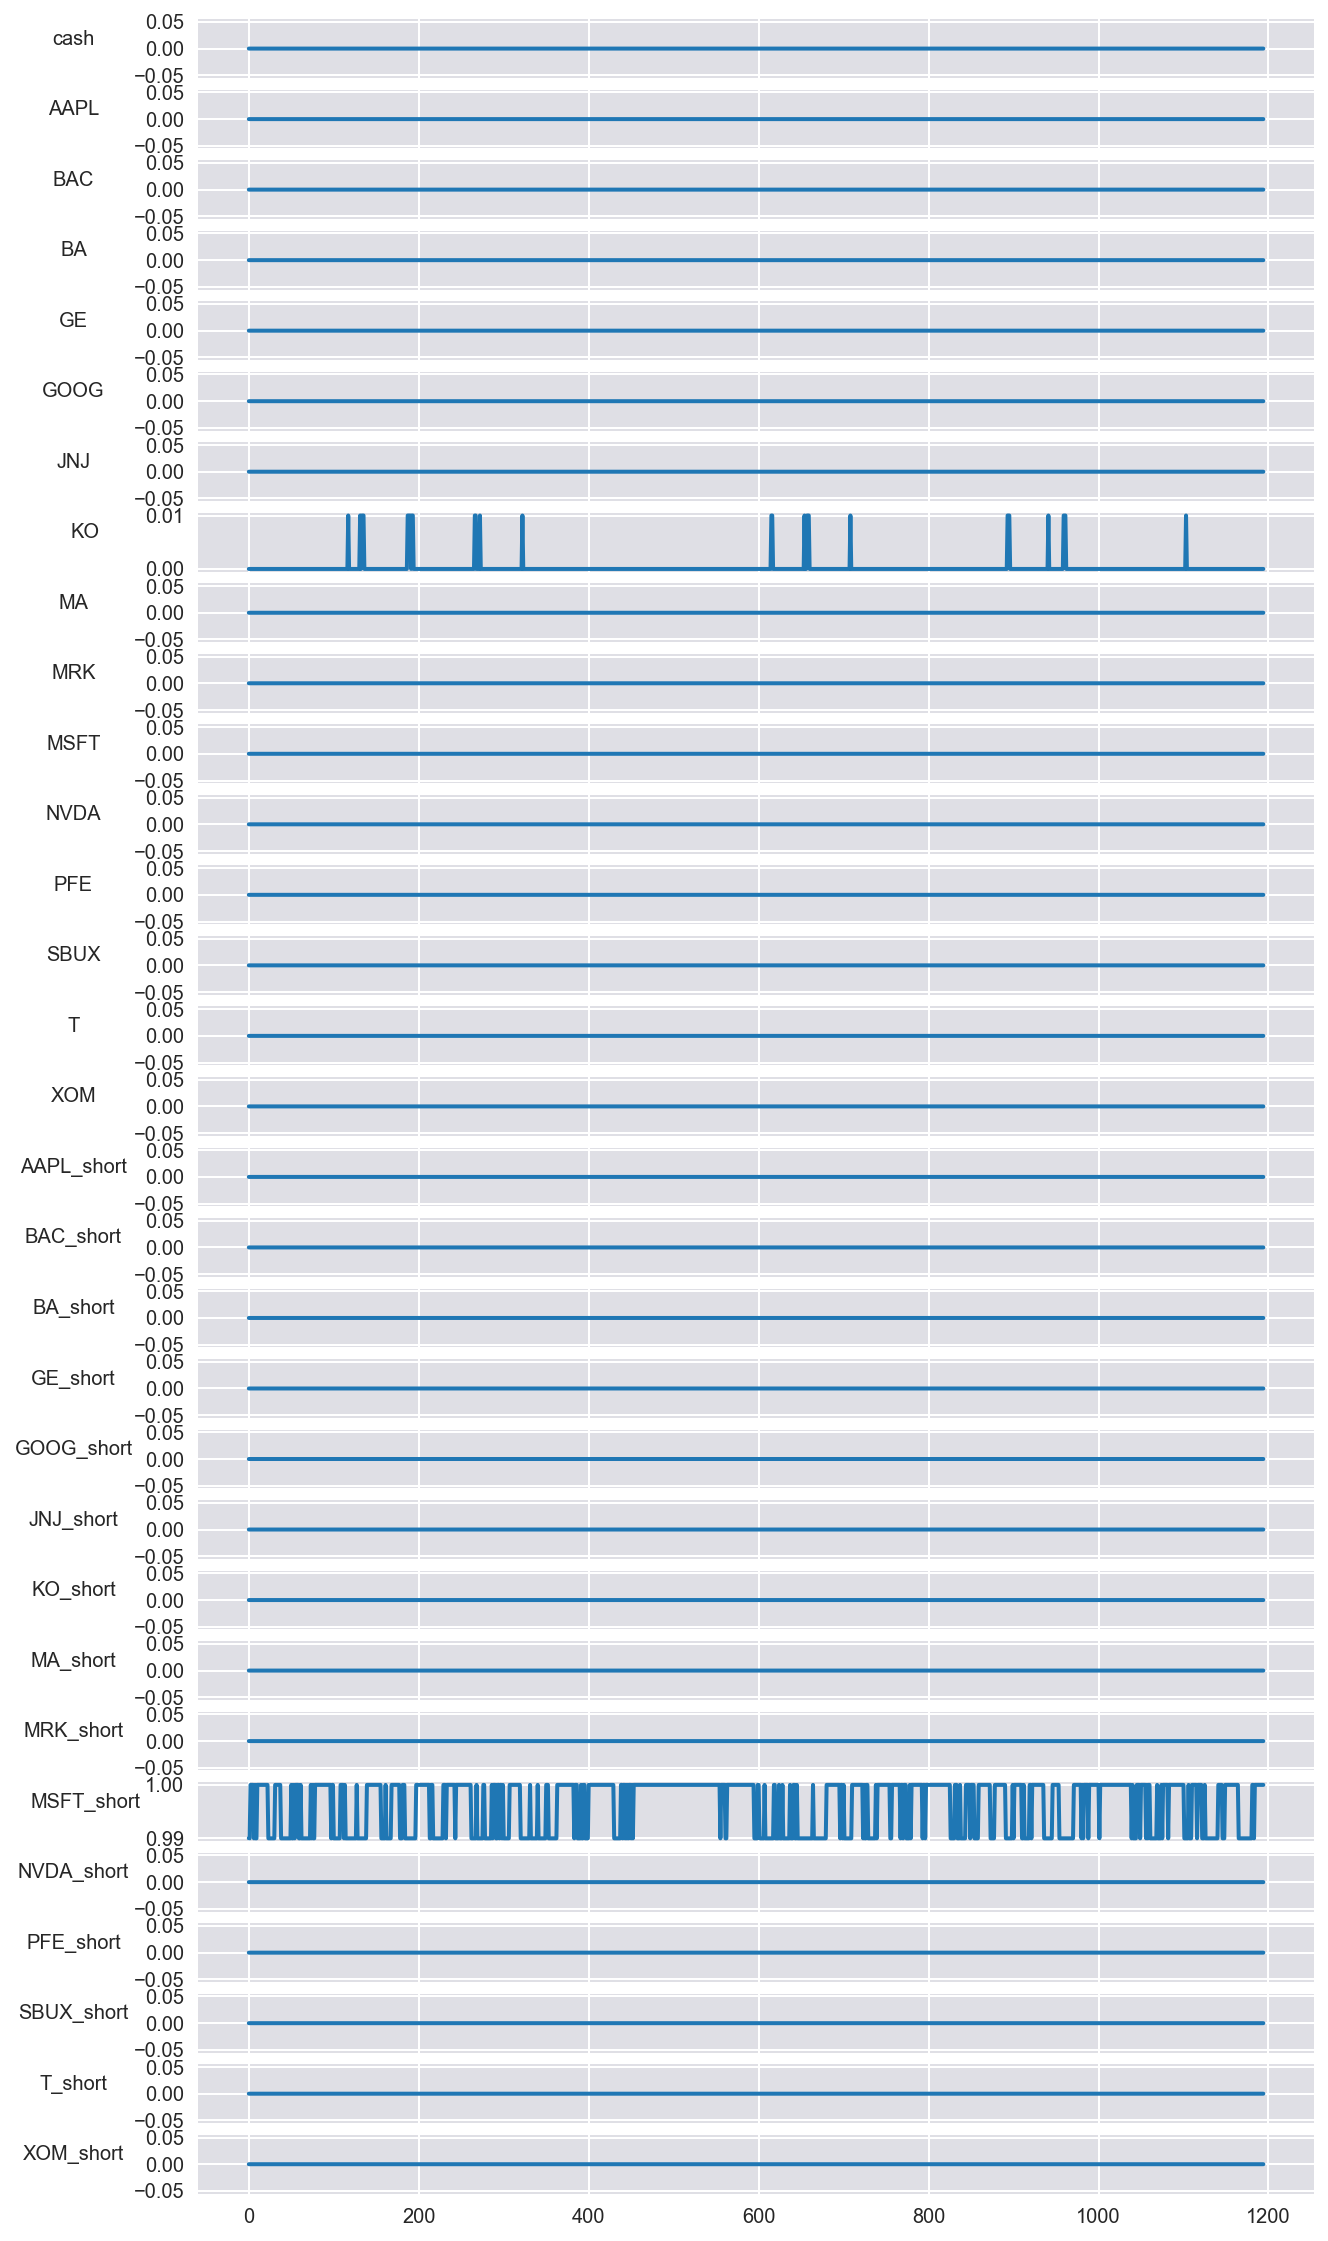

In [0]:
tf.reset_default_graph()
sess = tf.Session()
tflearn.config.init_training_mode()
action_dim = [nb_classes*2 + 1]
state_dim = [nb_classes + 1, window_length, 3]
variable_scope = get_variable_scope(window_length, predictor_type, use_batch_norm)
with tf.variable_scope(variable_scope):
    actor = StockActor(sess, state_dim, action_dim, action_bound, 1e-4, tau, batch_size, predictor_type, 
                       use_batch_norm)
    critic = StockCritic(sess=sess, state_dim=state_dim, action_dim=action_dim, tau=1e-3,
                         learning_rate=1e-3, num_actor_vars=actor.get_num_trainable_vars(), 
                         predictor_type=predictor_type, use_batch_norm=use_batch_norm)
    actor_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(action_dim))

    model_save_path = "weights/"
    summary_path = get_result_path(window_length, predictor_type, use_batch_norm)

    ddpg_model = DDPG(environ, sess, actor, critic, actor_noise,param, obs_normalizer=obs_normalizer, model_save_path=model_save_path,
                      summary_path=summary_path)
    ddpg_model.initialize(load_weights=False, verbose=False)
    ddpg_model.train()

env_Aug = PortfolioEnv(history_Aug, abbreviation, steps=history_Aug.shape[1]-200, window_length=window_length,
                   start_idx=data['Aug'].date_index.iloc[0])
test_model(env_Aug, ddpg_model)
plot_weights(env_Aug.infos)

INFO:tensorflow:Restoring parameters from weights/stock/lstm/window_30/batch_norm/Model_Aug/checkpoint.ckpt_Episode_1500/checkpoint.ckpt


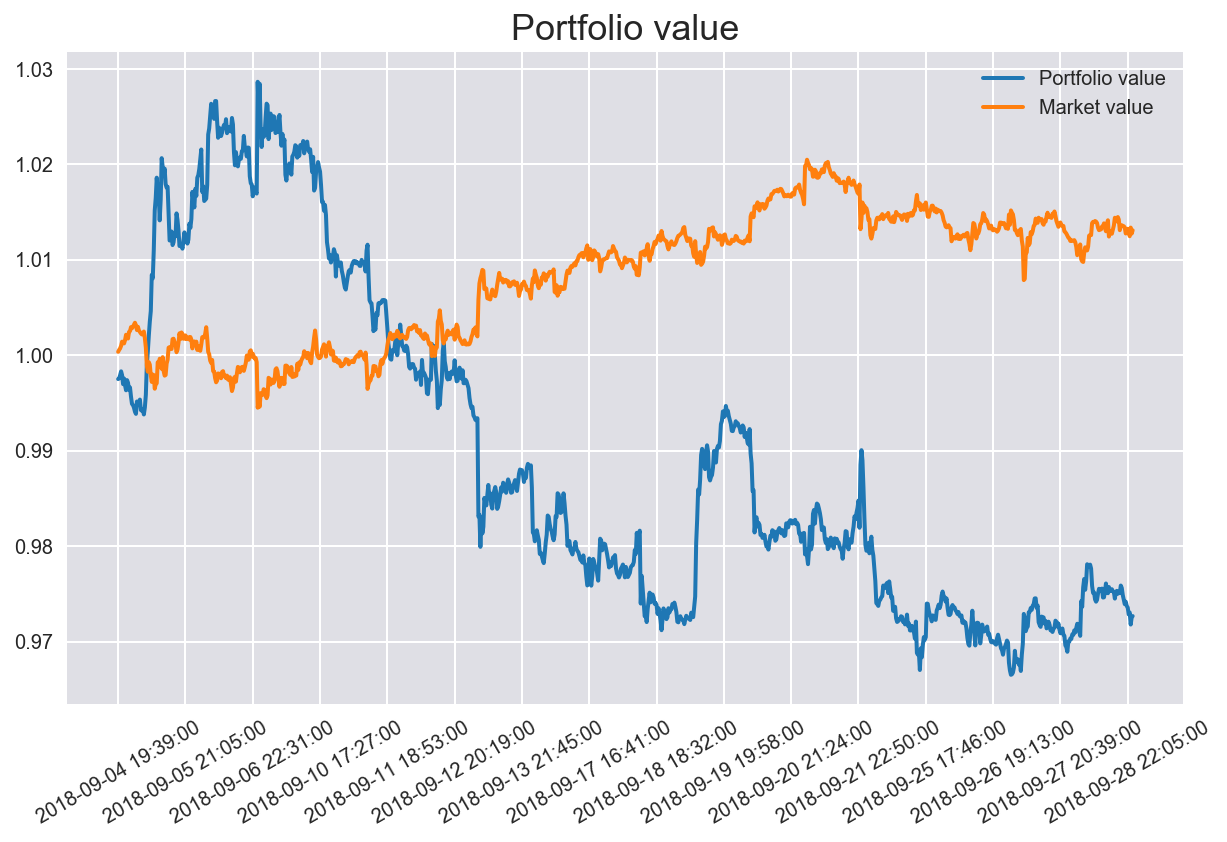

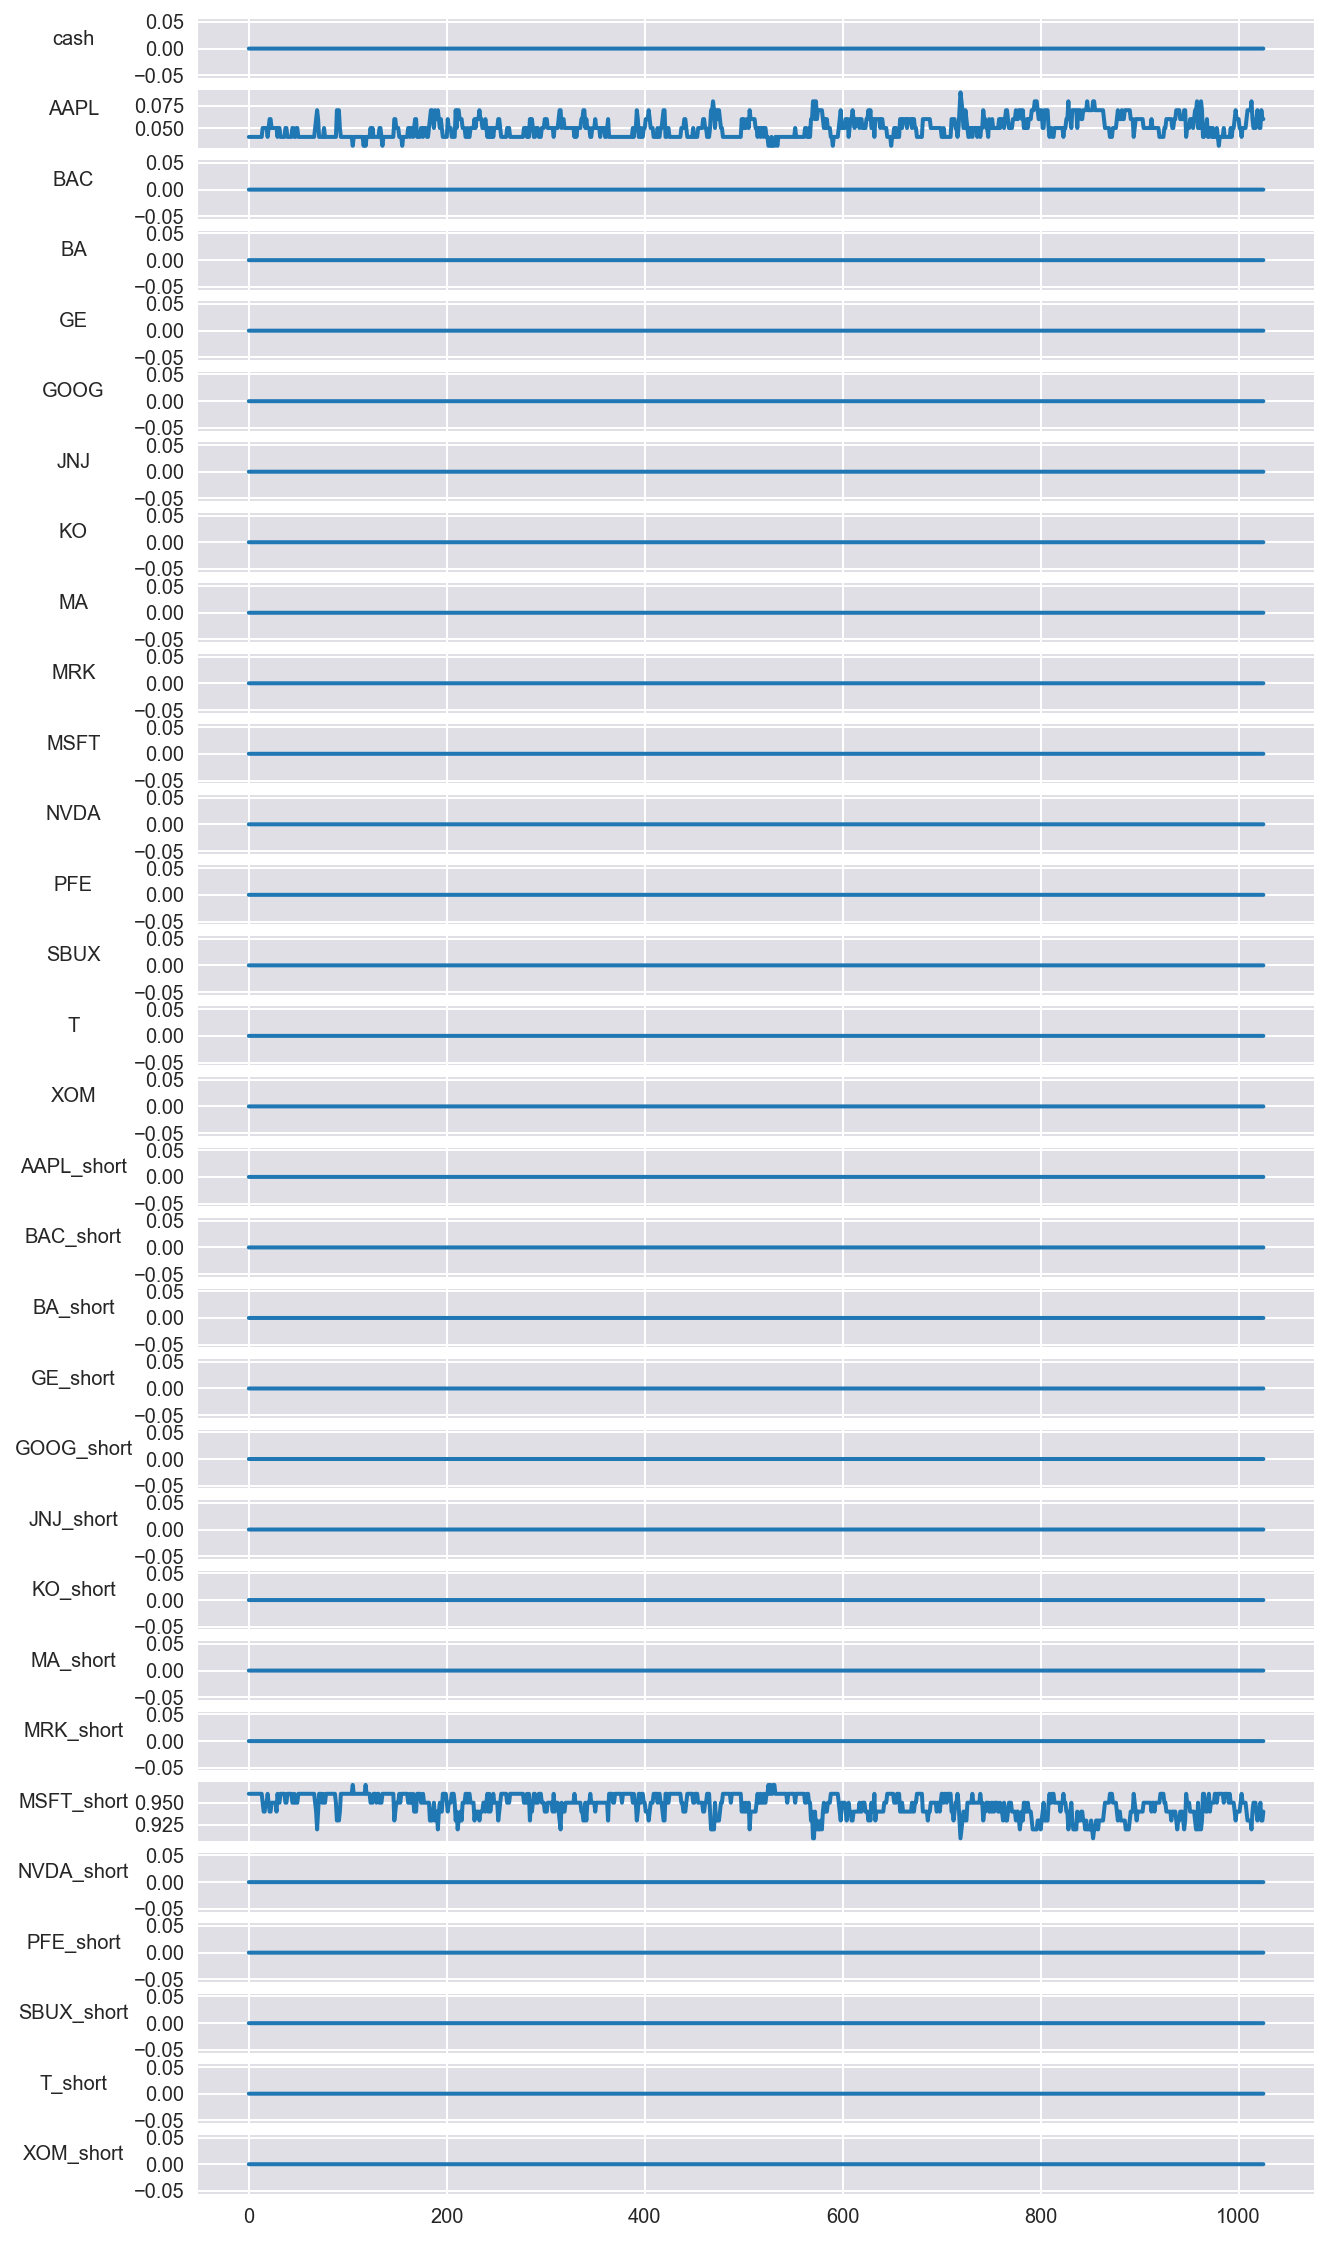

In [0]:
tf.reset_default_graph()
sess = tf.Session()
tflearn.config.init_training_mode()
action_dim = [nb_classes*2 + 1]
state_dim = [nb_classes + 1, window_length, 3]
variable_scope = get_variable_scope(window_length, predictor_type, use_batch_norm)
with tf.variable_scope(variable_scope):
    actor = StockActor(sess, state_dim, action_dim, action_bound, 1e-4, tau, batch_size, predictor_type, 
                       use_batch_norm)
    critic = StockCritic(sess=sess, state_dim=state_dim, action_dim=action_dim, tau=1e-3,
                         learning_rate=1e-3, num_actor_vars=actor.get_num_trainable_vars(), 
                         predictor_type=predictor_type, use_batch_norm=use_batch_norm)
    actor_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(action_dim))

    model_save_path = "weights/"
    summary_path = get_result_path(window_length, predictor_type, use_batch_norm)

    ddpg_model = DDPG(environ, sess, actor, critic, actor_noise,param, obs_normalizer=obs_normalizer, model_save_path=model_save_path,
                      summary_path=summary_path)
    ddpg_model.initialize(load_weights=False, verbose=False)
    ddpg_model.train()

env_Sep = PortfolioEnv(history_Sep, abbreviation, steps=history_Sep.shape[1]-200, window_length=window_length,
                   start_idx=data['Sep'].date_index.iloc[0])
test_model(env_Sep, ddpg_model)
plot_weights(env_Sep.infos)

Build model from scratch
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'
1500
[0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03
 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03
 0.03 0.03 0.03]
[0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03
 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03
 0.03 0.03 0.03]
Episode: 0, Reward: 1.00, Qmax: 0.0000
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'
Type is unsupported, or the types of the items don't match field ty

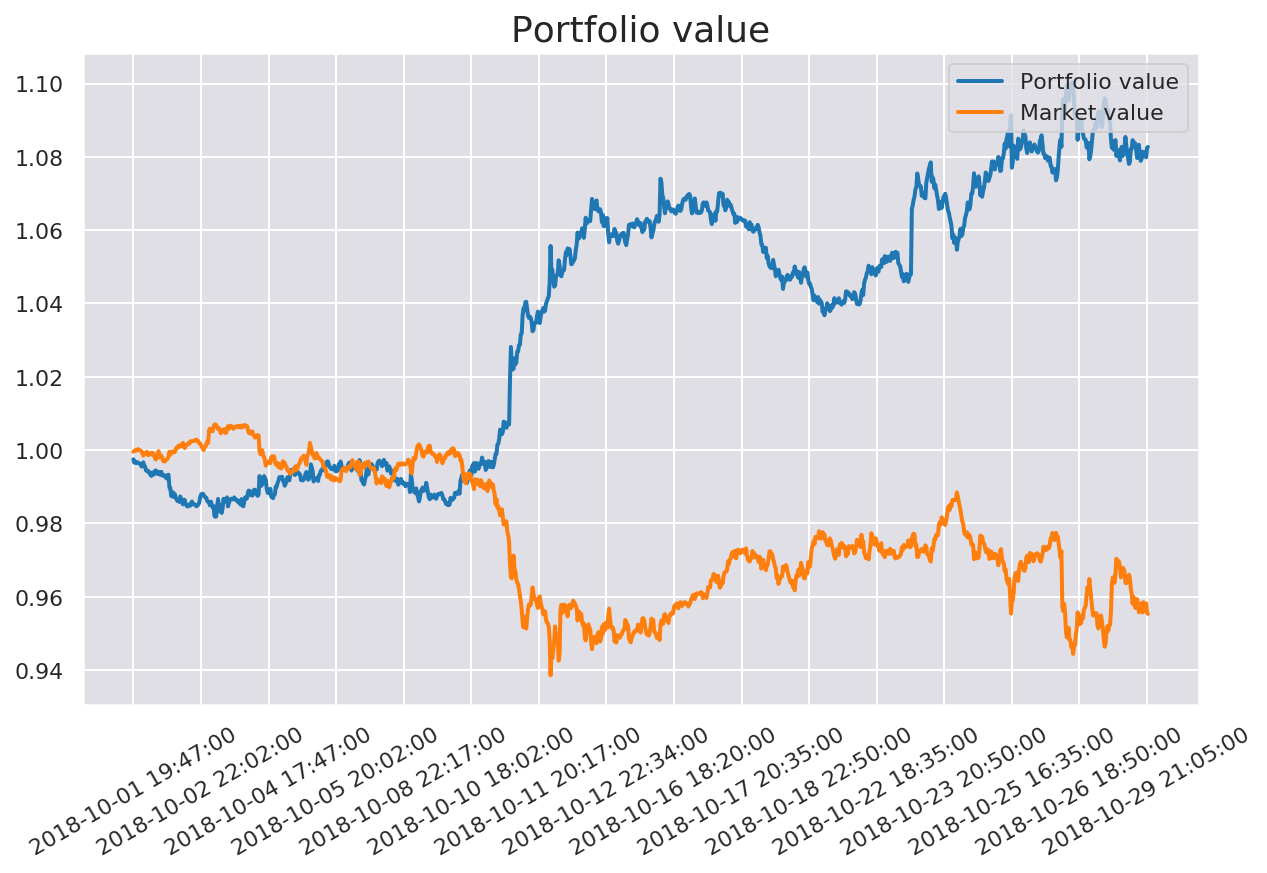

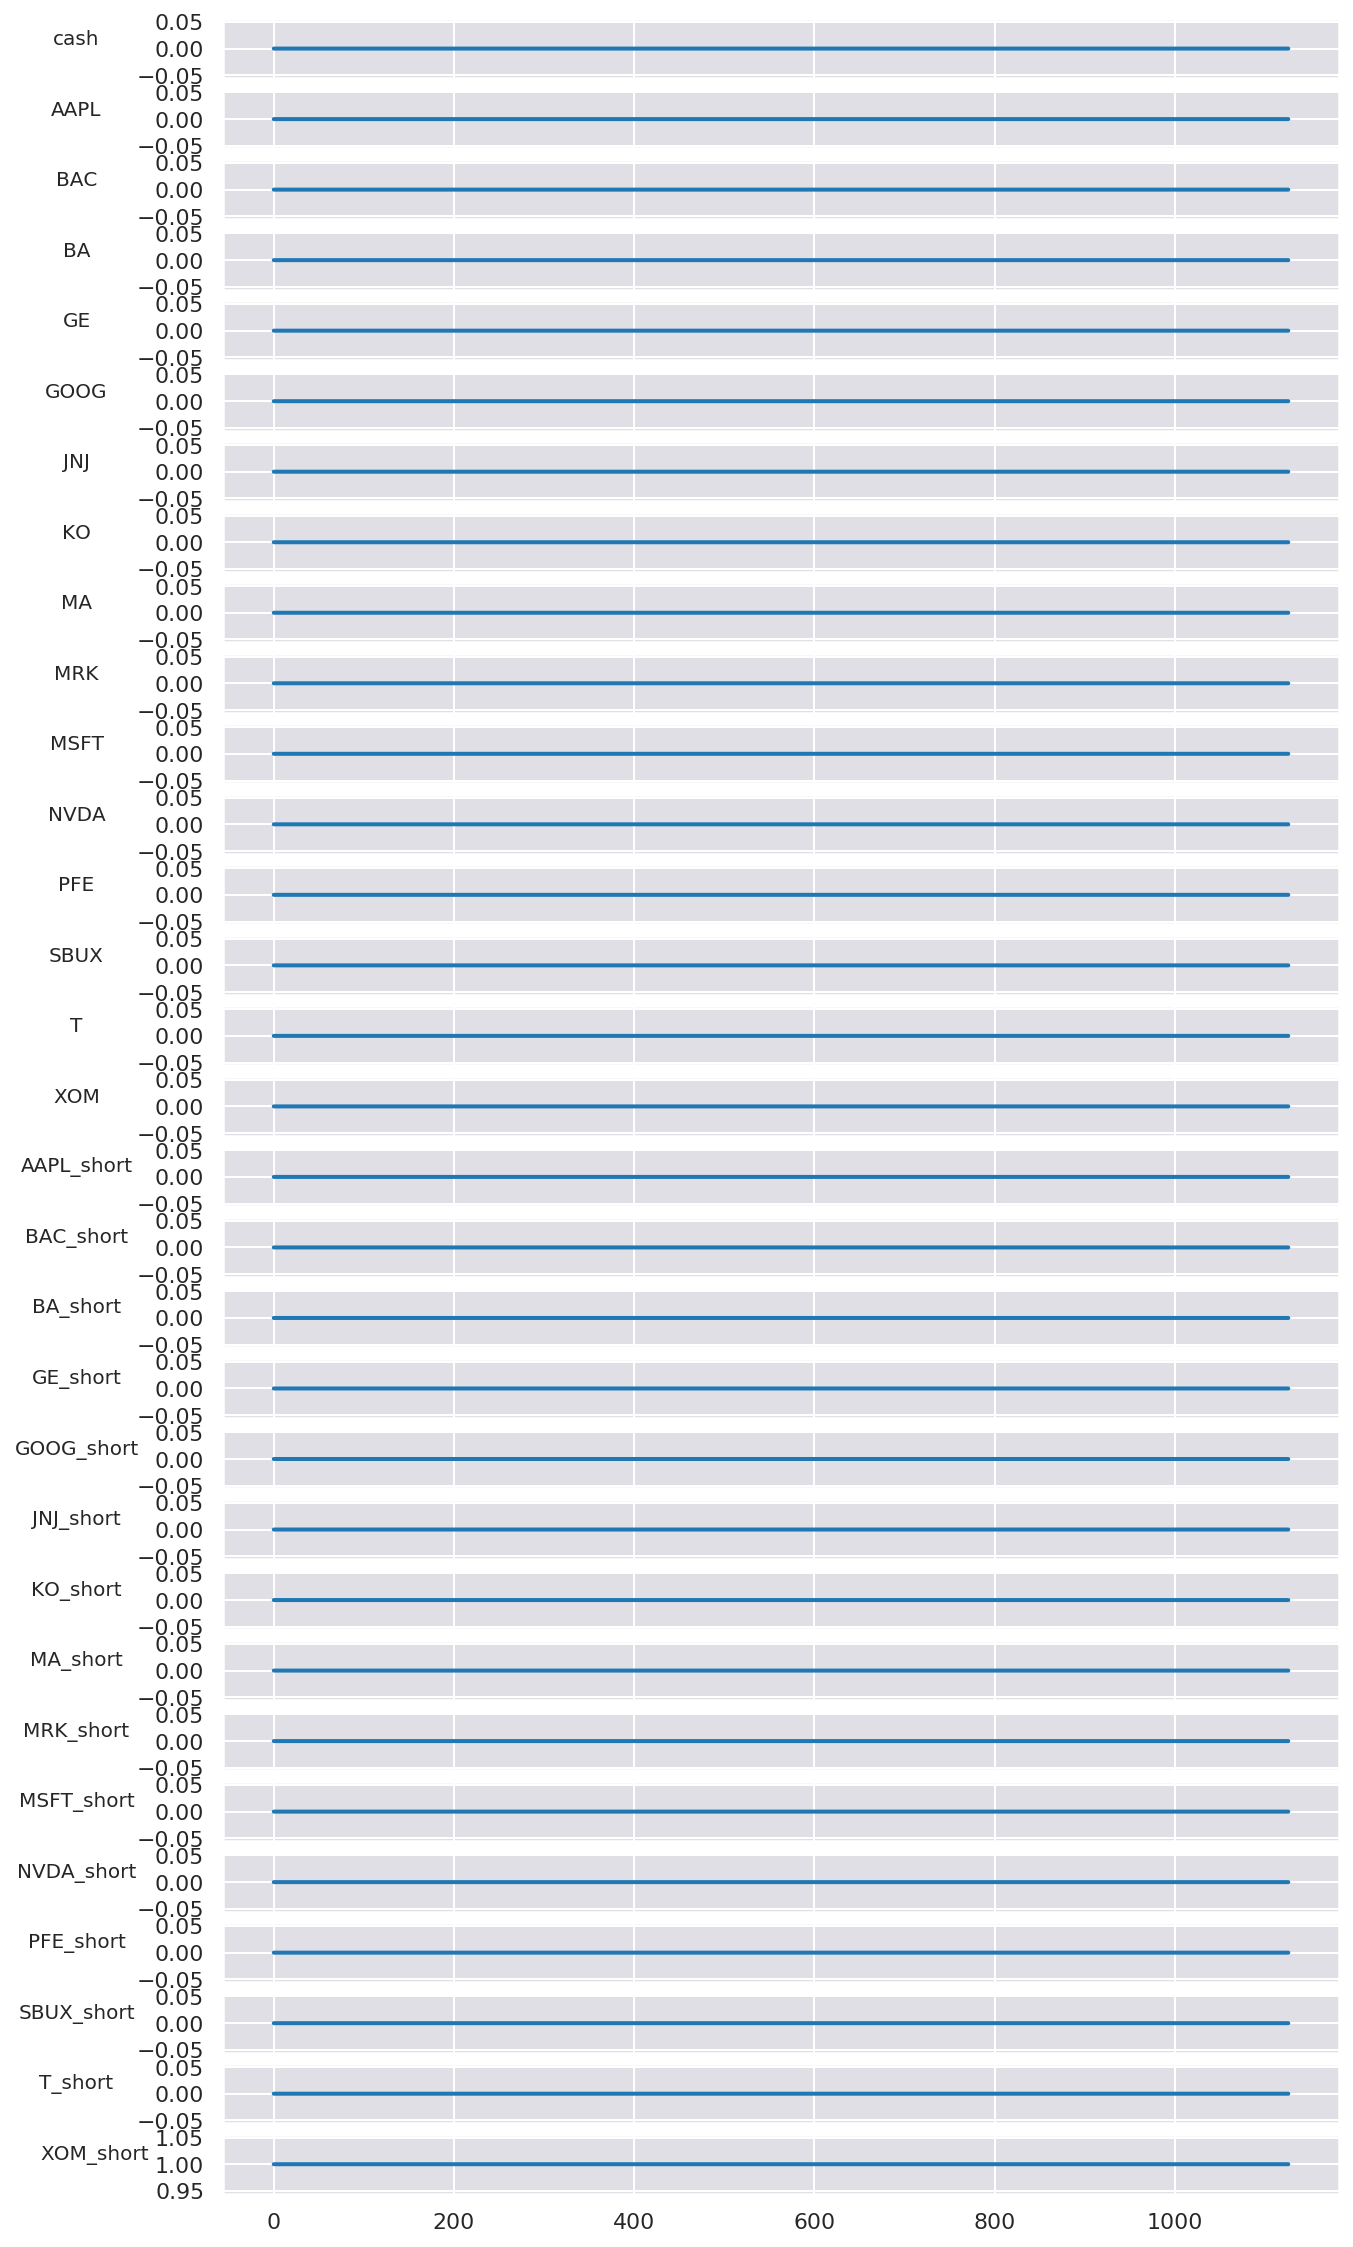

In [0]:
tf.reset_default_graph()
sess = tf.Session()
tflearn.config.init_training_mode()
action_dim = [nb_classes*2 + 1]
state_dim = [nb_classes + 1, window_length, 3]
variable_scope = get_variable_scope(window_length, predictor_type, use_batch_norm)
with tf.variable_scope(variable_scope):
    actor = StockActor(sess, state_dim, action_dim, action_bound, 1e-4, tau, batch_size, predictor_type, 
                       use_batch_norm)
    critic = StockCritic(sess=sess, state_dim=state_dim, action_dim=action_dim, tau=1e-3,
                         learning_rate=1e-3, num_actor_vars=actor.get_num_trainable_vars(), 
                         predictor_type=predictor_type, use_batch_norm=use_batch_norm)
    actor_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(action_dim))

    model_save_path = "weights/"
    summary_path = get_result_path(window_length, predictor_type, use_batch_norm)

    ddpg_model = DDPG(environ, sess, actor, critic, actor_noise,param, obs_normalizer=obs_normalizer, model_save_path=model_save_path,
                      summary_path=summary_path)
    ddpg_model.initialize(load_weights=False, verbose=False)
    ddpg_model.train()

env_Oct = PortfolioEnv(history_Oct, abbreviation, steps=history_Oct.shape[1]-200, window_length=window_length,
                   start_idx=data['Oct'].date_index.iloc[0])
test_model(env_Oct, ddpg_model)
plot_weights(env_Oct.infos)

Final P/L from 2018/02/01 to 2018/10/29

In [0]:
1*env_Feb.infos[-1]['portfolio_value']*env_Mar.infos[-1]['portfolio_value']*env_Apr.infos[-1]['portfolio_value']*env_May.infos[-1]['portfolio_value']*env_Jun.infos[-1]['portfolio_value']*env_Jul.infos[-1]['portfolio_value']*env_Aug.infos[-1]['portfolio_value']*env_Sep.infos[-1]['portfolio_value']*env_Oct.infos[-1]['portfolio_value']

1.146375231650955

Benchmark - buy every stock(no short position) uniformly and hold.

In [0]:
1*env_Feb.infos[-1]['market_value']*env_Mar.infos[-1]['market_value']*env_Apr.infos[-1]['market_value']*env_May.infos[-1]['market_value']*env_Jun.infos[-1]['market_value']*env_Jul.infos[-1]['market_value']*env_Aug.infos[-1]['market_value']*env_Sep.infos[-1]['market_value']*env_Oct.infos[-1]['market_value']

1.0563464635195277

Benchmark - buy stock with best performance last month

In [0]:
month = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct']

In [0]:
performance = dict()
for i in month:
    performance[i]=dict()

In [0]:
for j in month:
    for i in abbreviation['symbols']:
        value_change = data[j].loc[:, i+'_close'].iloc[-1]/data[j].loc[:, i+'_open'].iloc[0]
        performance[j][i] = value_change

In [0]:
performance

{'Jan': {'AAPL': 0.9809613350569985,
  'BAC': 1.0711409395973155,
  'BA': 1.1435526404760297,
  'GE': 0.9075654152445962,
  'GOOG': 1.1104635913185719,
  'JNJ': 1.0216394382344511,
  'KO': 1.0336527989544761,
  'MA': 1.1005921052631578,
  'MRK': 1.0740937223695846,
  'MSFT': 1.0773875181422352,
  'NVDA': 1.240461719188927,
  'PFE': 1.0402472527472528,
  'SBUX': 0.9887698686938492,
  'T': 0.9613118114271074,
  'XOM': 1.0366261035552375},
 'Feb': {'AAPL': 1.0695417789757413,
  'BAC': 1.0147243107769424,
  'BA': 1.0790539541759054,
  'GE': 0.909746161078032,
  'GOOG': 0.962603973327834,
  'JNJ': 0.9241829148548183,
  'KO': 0.9207753898019385,
  'MA': 1.0532261438689818,
  'MRK': 0.9018768521567336,
  'MSFT': 1.017782088587132,
  'NVDA': 1.0131714344515332,
  'PFE': 0.9716134143121206,
  'SBUX': 0.9899528219465316,
  'T': 0.9834754797441363,
  'XOM': 0.8943613348676639},
 'Mar': {'AAPL': 0.9411929431531784,
  'BAC': 0.9254284390921723,
  'BA': 0.8986408724721872,
  'GE': 0.9290144727773949

In [0]:
import operator
best_of_month = []
for i in month[:-1]:
    best_of_month.append(max(performance[i].items(), key=operator.itemgetter(1))[0])

In [0]:
best_of_month

['NVDA', 'BA', 'SBUX', 'MRK', 'NVDA', 'MRK', 'BAC', 'NVDA', 'BA']

In [0]:
month_invest = ['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct']

In [0]:
outcome = []
for i in range(9):
    outcome.append(performance[month_invest[i]][best_of_month[i]])

In [0]:
outcome

[1.0131714344515332,
 0.8986408724721872,
 1.0146036161335188,
 1.0015254237288136,
 0.9323994648618872,
 1.0678747940691926,
 0.9932713873758411,
 1.0034982508745627,
 0.9068782786994382]

In [0]:
np.cumprod(outcome)[-1]

0.8326900679223337